# Network Intrusion Detection with Machine Learning

The main objective of this work is to develop a solution based on Machine Learning techniques for detecting suspicious activities that could compromise an organization's cybersecurity. The goal is to identify vulnerabilities and network attacks through the analysis of network traffic data.

The project follows an applied research methodology that includes data selection and preprocessing, training of Machine Learning models, and evaluating their performance. For this purpose, the UNSW-NB15 dataset is used, which contains samples of both normal and malicious network traffic and enables the identification of attacks such as Fuzzers, DoS, and Worms, among others.

Different classification systems are compared, including those based on supervised learning techniques (Naive Bayes, Random Forest, Logistic Regression, SVM) and unsupervised learning techniques (K-Means and DBSCAN). Deep learning models are also utilized to optimize predictions. Results are evaluated using metrics such as accuracy, precision, recall, and F1-score to validate the ability to detect threats.

In [75]:
%matplotlib inline
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.stats import mode

from sklearn.cluster import KMeans, DBSCAN
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
)

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore")

# 1 Loading Data: UNSW-NB15 

## Reading the dataset

In [3]:
file_names = [f"UNSW-NB15_{i}.csv" for i in range(1, 5)]
all_data_df = pd.concat((pd.read_csv(file_name, header=None) for file_name in file_names), ignore_index=True)

In [7]:
features_df = pd.read_csv("UNSW-NB15_features.csv", encoding="ISO-8859-1")
features_df["Name"] = features_df["Name"].apply(lambda x: x.strip().replace(" ", "").lower())
all_data_df.columns = features_df["Name"]

In [8]:
all_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  sload             float64
 15  dload             float64
 16  spkts             int64  
 17  dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  sjit          

In [9]:
all_data_df.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


## Cleaning the dataset

### Null handling

In [10]:
null_columns = all_data_df.isnull().sum()
print(null_columns[null_columns > 0])

Name
ct_flw_http_mthd    1348145
is_ftp_login        1429879
attack_cat          2218764
dtype: int64


Fixing attack_cat feature:

In [11]:
filtered_df = all_data_df[(all_data_df["attack_cat"].isnull()) & (all_data_df["label"] == 0)]
print(f"Number of rows with null in 'attack_cat' and 0 in 'label': {len(filtered_df)}")

Number of rows with null in 'attack_cat' and 0 in 'label': 2218764


In [12]:
all_data_df["attack_cat"].value_counts()

attack_cat
Generic             215481
Exploits             44525
 Fuzzers             19195
DoS                  16353
 Reconnaissance      12228
 Fuzzers              5051
Analysis              2677
Backdoor              1795
Reconnaissance        1759
 Shellcode            1288
Backdoors              534
Shellcode              223
Worms                  174
Name: count, dtype: int64

In [13]:
# All null values in attack_cat column, are 0 (normal) in label column so we can fill them with "normal"
all_data_df["attack_cat"] = all_data_df.attack_cat.fillna(value="normal").apply(lambda x: x.strip().lower())
all_data_df["attack_cat"] = all_data_df["attack_cat"].apply(lambda x: "backdoor" if "backdoor" in x else x)
all_data_df["attack_cat"].value_counts()

attack_cat
normal            2218764
generic            215481
exploits            44525
fuzzers             24246
dos                 16353
reconnaissance      13987
analysis             2677
backdoor             2329
shellcode            1511
worms                 174
Name: count, dtype: int64

Fixing ct_flw_http_mthd feature:

In [14]:
all_data_df["ct_flw_http_mthd"].value_counts()

ct_flw_http_mthd
0.0     986791
1.0     188008
6.0       7902
4.0       6564
3.0        738
2.0        588
5.0        430
9.0        270
14.0       224
12.0       132
30.0        60
8.0         56
16.0        48
36.0        36
10.0        30
25.0        25
Name: count, dtype: int64

In [15]:
all_data_df["ct_flw_http_mthd"] = all_data_df.ct_flw_http_mthd.fillna(value=0)

Fixing is_ftp_login feature:

In [16]:
all_data_df["is_ftp_login"].value_counts()

is_ftp_login
0.0    1066593
1.0      43389
4.0        156
2.0         30
Name: count, dtype: int64

In [17]:
all_data_df["is_ftp_login"] = (all_data_df.is_ftp_login.fillna(value=0)).astype(int)

Checking all null values are fixed:

In [18]:
null_columns = all_data_df.isnull().sum()
print(null_columns[null_columns > 0])

Series([], dtype: int64)


### Incorrect Data Types Handling

In [19]:
features_df["Type"] = features_df["Type"].apply(lambda x: x.strip().replace(" ", "").lower())
correct_types = features_df.set_index("Name")["Type"].to_dict()

def check_column_type(column_name, column_data):
    expected_type = correct_types.get(column_name)
    if expected_type is None:
        return False
    if expected_type == "integer" or expected_type == "timestamp":
        return pd.api.types.is_integer_dtype(column_data)
    elif expected_type == "float":
        return pd.api.types.is_float_dtype(column_data)
    elif expected_type == "nominal":
        return pd.api.types.is_object_dtype(column_data)
    elif expected_type == "binary":
        return pd.api.types.is_integer_dtype(column_data) and set(column_data.unique()) == {0, 1}
    else:
        return False

incorrect_columns = [col for col in all_data_df.columns if not check_column_type(col, all_data_df[col])]

print("Columns with incorrect types:")
print(incorrect_columns)

Columns with incorrect types:
['sport', 'dsport', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd']


Fixing ct_ftp_cmd feature:

In [20]:
all_data_df["ct_ftp_cmd"].value_counts()

ct_ftp_cmd
     1429879
0    1056339
1      22990
1      17087
0      10159
2       1234
4        804
3        729
6        332
5        290
4        156
2         30
8         18
Name: count, dtype: int64

In [21]:
all_data_df["ct_ftp_cmd"] = all_data_df["ct_ftp_cmd"].replace(to_replace=' ', value=0).astype(int)
all_data_df["ct_ftp_cmd"].value_counts()

ct_ftp_cmd
0    2496377
1      40077
2       1264
4        960
3        729
6        332
5        290
8         18
Name: count, dtype: int64

Fixing is_ftp_login feature:

In [22]:
all_data_df["is_ftp_login"].value_counts()

is_ftp_login
0    2496472
1      43389
4        156
2         30
Name: count, dtype: int64

In [23]:
all_data_df["is_ftp_login"] = np.where(all_data_df["is_ftp_login"]>1, 1, all_data_df["is_ftp_login"])
all_data_df["is_ftp_login"].value_counts()

is_ftp_login
0    2496472
1      43575
Name: count, dtype: int64

Fixing ct_flw_http_mthd feature:

In [24]:
all_data_df["ct_flw_http_mthd"].value_counts()

ct_flw_http_mthd
0.0     2334936
1.0      188008
6.0        7902
4.0        6564
3.0         738
2.0         588
5.0         430
9.0         270
14.0        224
12.0        132
30.0         60
8.0          56
16.0         48
36.0         36
10.0         30
25.0         25
Name: count, dtype: int64

In [25]:
all_data_df["ct_flw_http_mthd"] = all_data_df["ct_flw_http_mthd"].astype(int)
all_data_df["ct_flw_http_mthd"].value_counts()

ct_flw_http_mthd
0     2334936
1      188008
6        7902
4        6564
3         738
2         588
5         430
9         270
14        224
12        132
30         60
8          56
16         48
36         36
10         30
25         25
Name: count, dtype: int64

Fixing sport feature:

In [26]:
all_data_df["sport"].value_counts()

sport
1043     216289
47439    198580
0         50432
47439      4689
1043       4033
          ...  
33785         1
2637          1
29900         1
3664          1
706           1
Name: count, Length: 100341, dtype: int64

In [27]:
def is_convertible_to_int(value):
    try:
        int(value)
        return True
    except ValueError:
        return False
    
non_convertible_values = all_data_df[~all_data_df["sport"].apply(is_convertible_to_int)]["sport"]

print("Values in 'sport' that cannot be converted to int:")
print(non_convertible_values.value_counts())

Values in 'sport' that cannot be converted to int:
sport
0x000c    4
0x000b    2
-         2
Name: count, dtype: int64


In [28]:
def convert_value(value):
    try:
        if isinstance(value, str) and value.startswith('0x'):
            return int(value, 16)  # Convert hexadecimal values to ints
        elif value == '-':
            return 0 
        else:
            return int(value) 
    except ValueError:
        return 0 

all_data_df["sport"] = all_data_df["sport"].apply(convert_value)

Fixing dsport feature:

In [29]:
all_data_df["dsport"].value_counts()

dsport
53       619538
53       179430
80       126921
80        99777
5190      64352
          ...  
16465         1
5723          1
29159         1
24179         1
30870         1
Name: count, Length: 128297, dtype: int64

In [30]:
non_convertible_values = all_data_df[~all_data_df["dsport"].apply(is_convertible_to_int)]["dsport"]

print("Values in 'dsport' that cannot be converted to int:")
print(non_convertible_values.value_counts())

Values in 'dsport' that cannot be converted to int:
dsport
0xcc09        241
0xc0a8         54
-               7
0x20205321      2
Name: count, dtype: int64


In [31]:
all_data_df["dsport"] = all_data_df["sport"].apply(convert_value)

Checking all incorrect data types are fixed:

In [32]:
incorrect_columns = [col for col in all_data_df.columns if not check_column_type(col, all_data_df[col])]
print("Columns with incorrect types:")
print(incorrect_columns)

Columns with incorrect types:
[]


## Dividing the dataset

In [33]:
train, test = train_test_split(all_data_df, test_size=0.3, random_state=16)

### Class distribution

In [34]:
train_label_percentages = train["label"].value_counts(normalize=True) * 100
test_label_percentages = test["label"].value_counts(normalize=True) * 100

train_attack_cat_percentages = train["attack_cat"].value_counts(normalize=True) * 100
test_attack_cat_percentages = test["attack_cat"].value_counts(normalize=True) * 100

print("In Train (label):")
for label, percentage in train_label_percentages.items():
    print(f"Class {label}: {percentage:.2f}%")

print("\nIn Test (label):")
for label, percentage in test_label_percentages.items():
    print(f"Class {label}: {percentage:.2f}%")

print("\nIn Train (attack_cat):")
for category, percentage in train_attack_cat_percentages.items():
    print(f"Category {category}: {percentage:.2f}%")

print("\nIn Test (attack_cat):")
for category, percentage in test_attack_cat_percentages.items():
    print(f"Category {category}: {percentage:.2f}%")

In Train (label):
Class 0: 87.34%
Class 1: 12.66%

In Test (label):
Class 0: 87.39%
Class 1: 12.61%

In Train (attack_cat):
Category normal: 87.34%
Category generic: 8.49%
Category exploits: 1.77%
Category fuzzers: 0.95%
Category dos: 0.64%
Category reconnaissance: 0.55%
Category analysis: 0.10%
Category backdoor: 0.09%
Category shellcode: 0.06%
Category worms: 0.01%

In Test (attack_cat):
Category normal: 87.39%
Category generic: 8.47%
Category exploits: 1.71%
Category fuzzers: 0.96%
Category dos: 0.65%
Category reconnaissance: 0.55%
Category analysis: 0.11%
Category backdoor: 0.09%
Category shellcode: 0.06%
Category worms: 0.01%


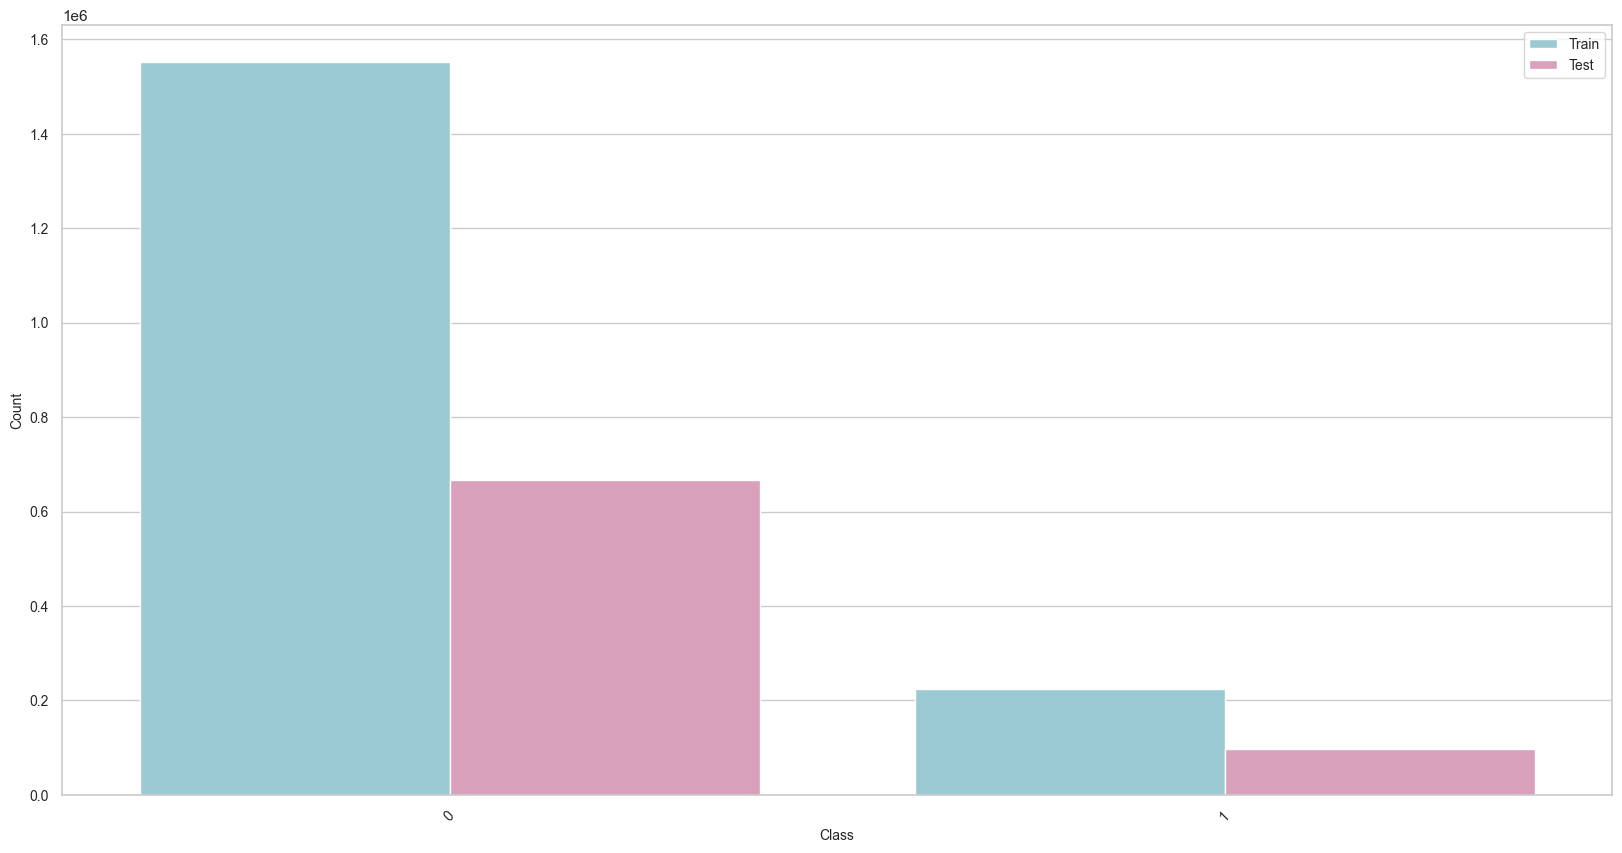

In [35]:
sns.set(style="whitegrid")

train_label_counts = train["label"].value_counts().reset_index()
train_label_counts.columns = ["label", "count"]
train_label_counts["dataset"] = "Train"

test_label_counts = test["label"].value_counts().reset_index()
test_label_counts.columns = ["label", "count"]
test_label_counts["dataset"] = "Test"

label_counts = pd.concat([train_label_counts, test_label_counts])

plt.figure(figsize=(20, 10))

sns.barplot(x="label", y="count", hue="dataset", data=label_counts, palette=["#92d0db", "#e197bb"])

plt.xlabel("Class", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.show()

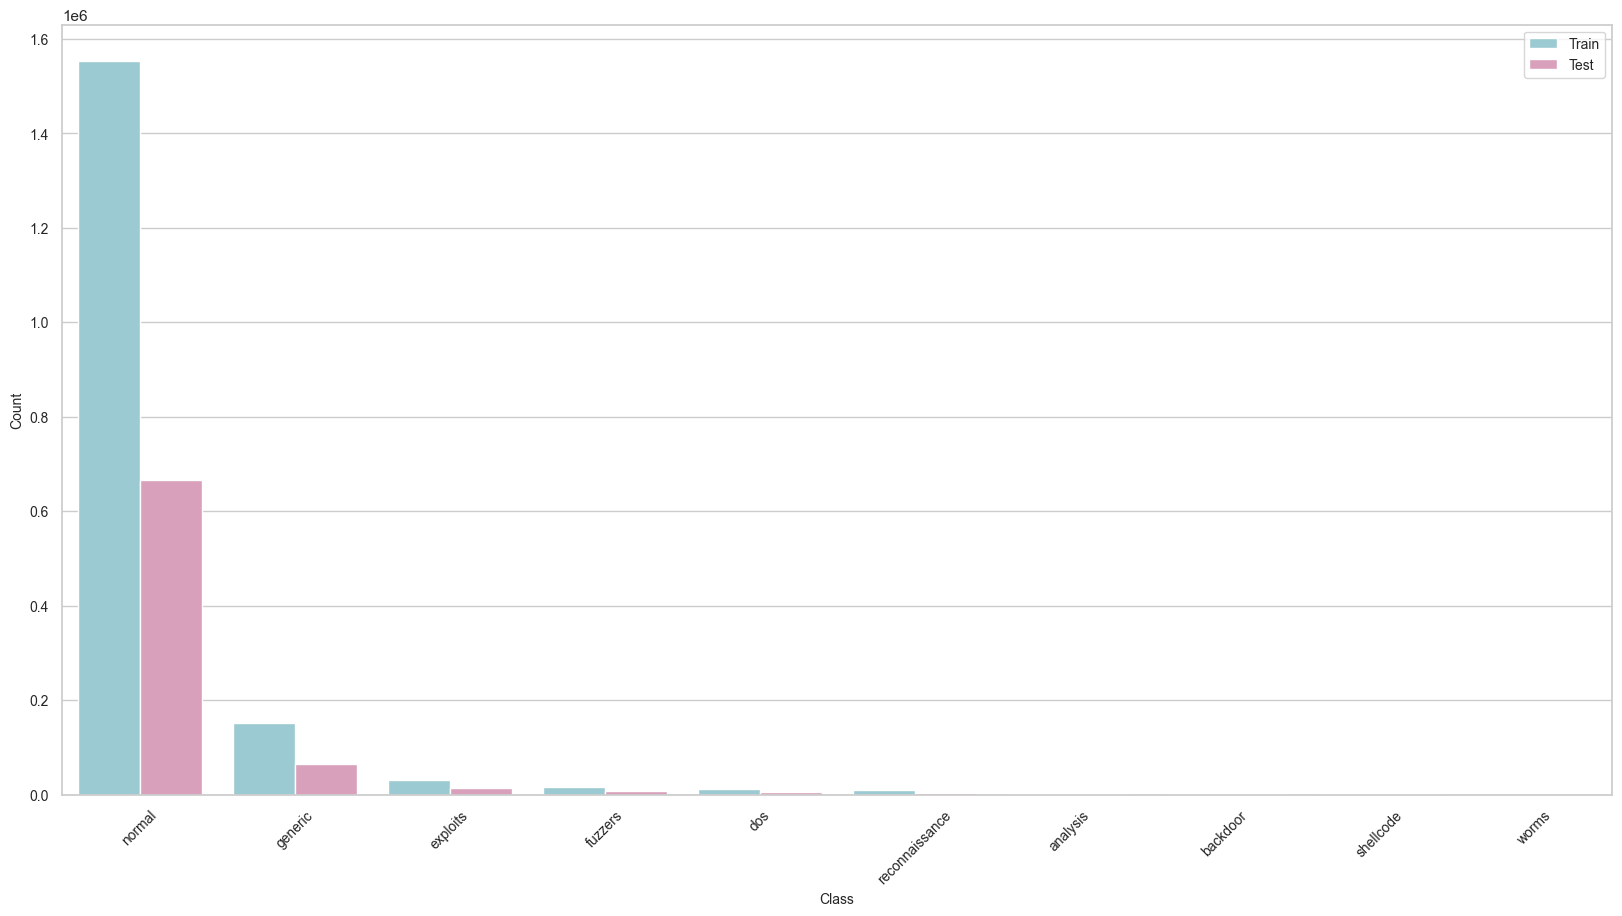

In [36]:
sns.set(style="whitegrid")

train_attack_counts = train["attack_cat"].value_counts().reset_index()
train_attack_counts.columns = ["attack_cat", "count"]
train_attack_counts["dataset"] = "Train"

test_attack_counts = test["attack_cat"].value_counts().reset_index()
test_attack_counts.columns = ["attack_cat", "count"]
test_attack_counts["dataset"] = "Test"

attack_counts = pd.concat([train_attack_counts, test_attack_counts])

plt.figure(figsize=(20, 10))

sns.barplot(x="attack_cat", y="count", hue="dataset", data=attack_counts, palette=["#92d0db", "#e197bb"])

plt.xlabel("Class", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.show()

### Saving training and testing datasets

In [37]:
train.to_csv("training_dataset.csv", index=False)
test.to_csv("testing_dataset.csv", index=False)

# 2 Preprocessing Data

## Loading train and test datasets

In [51]:
train = pd.read_csv("training_dataset.csv")
test = pd.read_csv("testing_dataset.csv")

## Preprocessing datasets

### Adding a new feature

In [90]:
# Total bytes transferred by the network = source bytes + destination bytes
train["nbytes"] = train["sbytes"] + train["dbytes"]
test["nbytes"] = test["sbytes"] + test["dbytes"]

### Deleting unuseful features

In [91]:
# Deleting all the columns that are address related
train.drop(columns=["srcip", "sport", "dstip", "dsport"], inplace=True)
test.drop(columns=["srcip", "sport", "dstip", "dsport"], inplace=True)

### Deleting highly correlataed features

In [92]:
def find_high_correlated_features(df: pd.DataFrame, correlation: float):
    numeric_data = df._get_numeric_data()
    correlation_matrix = numeric_data.corr().abs()
    upper_correlation = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    high_correlation_columns = [column for column in upper_correlation.columns if any(upper_correlation[column] > correlation)]

    return high_correlation_columns

high_correlation_columns = find_high_correlated_features(train, 0.95)
print(f"Features with a correlation greater than 0.95 with other features: \n{high_correlation_columns}")

Features with a correlation grater than 0.95 with other features: 
['sloss', 'dloss', 'dpkts', 'dwin', 'ltime', 'ct_srv_dst', 'ct_src_dport_ltm', 'ct_dst_src_ltm']


In [93]:
train.drop(columns=high_correlation_columns, inplace=True)
test.drop(columns=high_correlation_columns, inplace=True)
print(train.shape, test.shape)

(1778032, 38) (762015, 38)


### Applying log(1 + x)

In [94]:
def calculate_correlations(df: pd.DataFrame, feature1: str, feature2: str = "label"):
    """
    Calculate the correlation between feature1 and feature2,
    and between log1p-transformed feature1 and feature2.
    """
    correlation = df[[feature1, feature2]].corr().iloc[0, 1]
    log_correlation = df[feature1].apply(np.log1p).corr(df[feature2])

    return correlation, log_correlation

In [95]:
def get_continuous_features(df: pd.DataFrame, threshold: int):
    """
    Select numeric features with more than 'threshold' unique values.
    """
    numeric_columns = df.select_dtypes(include=[np.number])
    continuous_features = [
        col for col in numeric_columns if df[col].nunique() > threshold and df[col].min() >= 0
    ]
    return continuous_features

In [96]:
def apply_log1p_(df: pd.DataFrame, label_column: str = "label"):
    """
    Apply log1p transformation to continuous features if it improves correlation with the label.
    """
    log1p_features = []
    for feature in get_continuous_features(df, 200):
        correlation, log_correlation = calculate_correlations(df, feature, feature2=label_column)
        
        # Check skewness to ensure log1p makes sense
        skewness = df[feature].skew()
        
        if abs(log_correlation) > abs(correlation) and abs(skewness) >= 1:
            df[feature] = np.log1p(df[feature])
            log1p_features.append(feature)
    
    return log1p_features

In [97]:
log1p_train = apply_log1p_(train)
print(f"Applying log1p to {log1p_train}")
log1p_test = apply_log1p_(test)
print(f"Applying log1p to {log1p_test}")

Applying log1p to ['dur', 'sbytes', 'dbytes', 'sload', 'dload', 'spkts', 'smeansz', 'dmeansz', 'res_bdy_len', 'sjit', 'djit', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat', 'nbytes']
Applying log1p to ['dur', 'sbytes', 'dbytes', 'sload', 'dload', 'spkts', 'smeansz', 'dmeansz', 'res_bdy_len', 'sjit', 'djit', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat', 'nbytes']


### Dividing the dataset in X and Y sets

In [52]:
x_train, y_train, y_train_multiclass = train.drop(columns=["label", "attack_cat"]), train["label"], train["attack_cat"]
x_test, y_test, y_test_multiclass = test.drop(columns=["label", "attack_cat"]), test["label"], test["attack_cat"]

### Scaling and Encoding

In [101]:
numerical_features = x_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = x_train.select_dtypes(include=["object"]).columns.tolist()
print(f"Numerical columns: {numerical_features}")
print(f"Categorical columns: {categorical_features}")

Numerical columns: ['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sload', 'dload', 'spkts', 'swin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_dst_ltm', 'ct_src_ltm', 'ct_dst_sport_ltm', 'nbytes']
Categorical columns: ['proto', 'state', 'service']


Scaling numerical features and One-Hot Encoding categorical features

In [111]:
x_train["proto"].fillna("missing", inplace=True)
x_train["service"].fillna("missing", inplace=True)
x_train["state"].fillna("missing", inplace=True)

In [116]:
def apply_scaler_and_one_hot_encoding(df: pd.DataFrame, scaler):
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", scaler, numerical_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
        ]   
    )
    preprocessor.fit(x_train)
    return preprocessor.transform(df)

In [118]:
standard_scaler = StandardScaler()
x_train_standard = apply_scaler_and_one_hot_encoding(x_train, standard_scaler)
x_test_standard = apply_scaler_and_one_hot_encoding(x_test, standard_scaler)

In [119]:
robust_scaler = RobustScaler()
x_train_robust = apply_scaler_and_one_hot_encoding(x_train, robust_scaler)
x_test_robust = apply_scaler_and_one_hot_encoding(x_test, robust_scaler)

In [120]:
minmax_scaler = MinMaxScaler()
x_train_minmax = apply_scaler_and_one_hot_encoding(x_train, minmax_scaler)
x_test_minmax = apply_scaler_and_one_hot_encoding(x_test, minmax_scaler)

Label Encoding

In [53]:
# Encoding attack_cat feature
label_encoder = LabelEncoder()
y_train_multiclass = label_encoder.fit_transform(y_train_multiclass)
y_test_multiclass = label_encoder.transform(y_test_multiclass)

In [54]:
print("Order of labels:", label_encoder.classes_)

Order of labels: ['analysis' 'backdoor' 'dos' 'exploits' 'fuzzers' 'generic' 'normal'
 'reconnaissance' 'shellcode' 'worms']


In [125]:
print(x_train_standard.shape, x_test_standard.shape, x_train_minmax.shape, x_test_minmax.shape, x_train_robust.shape, x_test_robust.shape)

(1778032, 197) (762015, 197) (1778032, 197) (762015, 197) (1778032, 197) (762015, 197)


### PCA

In [134]:
def apply_pca(x_train, df: pd.DataFrame):
    pca = PCA(n_components=0.95)
    pca.fit(x_train.toarray())
    
    return pca.transform(df)

In [141]:
x_train_standard_pca = apply_pca(x_train_standard, x_train_standard)
x_test_standard_pca = apply_pca(x_train_standard, x_test_standard)
print(x_train_standard_pca.shape, x_test_standard_pca.shape)

(1778032, 17) (762015, 17)


In [142]:
x_train_robust_pca = apply_pca(x_train_robust, x_train_robust)
x_test_robust_pca = apply_pca(x_train_robust, x_test_robust)
print(x_train_robust_pca.shape, x_test_robust_pca.shape)

(1778032, 3) (762015, 3)


In [143]:
x_train_minmax_pca = apply_pca(x_train_minmax, x_train_minmax)
x_test_minmax_pca = apply_pca(x_train_minmax, x_test_minmax)
print(x_train_minmax_pca.shape, x_test_minmax_pca.shape)

(1778032, 12) (762015, 12)


## Saving preprocessed datasets

In [144]:
pickle.dump((x_train_standard, x_train_robust, x_train_minmax, y_train, y_train_multiclass), open("final_train.pkl", "wb"))
pickle.dump((x_test_standard, x_test_robust, x_test_minmax, y_test, y_test_multiclass), open("final_test.pkl", "wb"))

In [145]:
pickle.dump((x_train_standard_pca, x_train_robust_pca, x_train_minmax_pca, y_train, y_train_multiclass), open("final_train_pca.pkl", "wb"))
pickle.dump((x_test_standard_pca, x_test_robust_pca, x_test_minmax_pca, y_test, y_test_multiclass), open("final_test_pca.pkl", "wb"))

# 3 Training

## Loading data

In [56]:
x_train_standard_pca, x_train_robust_pca, x_train_minmax_pca, y_train, y_train_multiclass = pickle.load(open("final_train_pca.pkl", "rb"))
x_test_standard_pca, x_test_robust_pca, x_test_minmax_pca, y_test, y_test_multiclass = pickle.load(open("final_test_pca.pkl", "rb"))

In [57]:
x_train_standard_no_pca, x_train_robust_no_pca, x_train_minmax_no_pca, y_train, y_train_multiclass = pickle.load(open("final_train.pkl", "rb"))
x_test_standard_no_pca, x_test_robust_no_pca, x_test_minmax_no_pca, y_test, y_test_multiclass = pickle.load(open("final_test.pkl", "rb"))

In [58]:
x_train_csr = csr_matrix(x_train_standard_pca)
x_test_csr = csr_matrix(x_test_standard_pca)
x_train = pd.DataFrame.sparse.from_spmatrix(x_train_csr)
x_test = pd.DataFrame.sparse.from_spmatrix(x_test_csr)

In [59]:
x_train_robust_csr = csr_matrix(x_train_robust_pca)
x_test_robust_csr = csr_matrix(x_test_robust_pca)
x_train_robust = pd.DataFrame.sparse.from_spmatrix(x_train_robust_csr)
x_test_robust = pd.DataFrame.sparse.from_spmatrix(x_test_robust_csr)

In [60]:
x_train_minmax_csr = csr_matrix(x_train_minmax_pca)
x_test_minmax_csr = csr_matrix(x_test_minmax_pca)
x_train_minmax = pd.DataFrame.sparse.from_spmatrix(x_train_minmax_csr)
x_test_minmax = pd.DataFrame.sparse.from_spmatrix(x_test_minmax_csr)

In [61]:
x_train_csr.shape, x_test_csr.shape, y_train.shape, y_test.shape

((1778032, 17), (762015, 17), (1778032,), (762015,))

In [62]:
x_train_robust_csr.shape, x_test_robust_csr.shape

((1778032, 3), (762015, 3))

In [63]:
x_train_minmax_csr.shape, x_test_minmax_csr.shape

((1778032, 12), (762015, 12))

In [66]:
labels_binary = ["normal", "attack"]
labels_multiclass = [
    "analysis", 
    "backdoor",
    "dos",
    "exploits",
    "fuzzers",
    "generic",
    "normal",
    "reconnaissance",
    "shellcode",
    "worms",
]

## Defining useful functions

In [8]:
def tune_hyperparameters(clf, parameters: dict, x, y, cv = None):

    scoring = {
        "accuracy": "accuracy",
        "f1_weighted": "f1_weighted",
        "precision_weighted": "precision_weighted",
        "recall_weighted": "recall_weighted"
    }
                
    tuning_clf = GridSearchCV(clf, parameters, scoring=scoring, refit="accuracy", cv=cv, verbose=3, return_train_score=True)
    return tuning_clf.fit(x, y)

In [9]:
def result_visualization(tuned_clf, parameters, metric="accuracy", param1=None, param2=None):
    
    if f"mean_train_{metric}" not in tuned_clf.cv_results_ or f"mean_test_{metric}" not in tuned_clf.cv_results_:
        raise ValueError(f"The metric '{metric}' is not available in the tuning results.")

    train_score = tuned_clf.cv_results_[f"mean_train_{metric}"]
    test_score = tuned_clf.cv_results_[f"mean_test_{metric}"]

    print(f"Best {metric.capitalize()} Score: {tuned_clf.best_score_}")
    print(f"Best Parameters: {tuned_clf.best_params_}")

    train_cmap = sns.light_palette("#92d0db", as_cmap=True)
    test_cmap = sns.light_palette("#e197bb", as_cmap=True)

    fig = plt.figure(figsize=(20, 5))
    train_ax = fig.add_subplot(1, 2, 1)
    test_ax = fig.add_subplot(1, 2, 2)

    if param2 is None:
        # Train heatmap
        sns.heatmap(
            train_score.reshape(len(parameters[param1]), 1),
            cmap=train_cmap, annot=True, fmt='.4f', ax=train_ax,
            xticklabels=[''], yticklabels=parameters[param1]
        )

        # Test heatmap
        sns.heatmap(
            test_score.reshape(len(parameters[param1]), 1),
            cmap=test_cmap, annot=True, fmt='.4f', ax=test_ax,
            xticklabels=[''], yticklabels=parameters[param1]
        )

        train_ax.set_title(f"Train {metric.capitalize()} Heatmap")
        train_ax.set_xlabel('')
        train_ax.set_ylabel(param1)

        test_ax.set_title(f"Test {metric.capitalize()} Heatmap")
        test_ax.set_xlabel('')
        test_ax.set_ylabel(param1)
    else:
        # Train heatmap
        sns.heatmap(
            train_score.reshape(len(parameters[param1]), len(parameters[param2])),
            cmap=train_cmap, annot=True, fmt='.4f', ax=train_ax,
            xticklabels=parameters[param2], yticklabels=parameters[param1]
        )

        # Test heatmap
        sns.heatmap(
            test_score.reshape(len(parameters[param1]), len(parameters[param2])),
            cmap=test_cmap, annot=True, fmt='.4f', ax=test_ax,
            xticklabels=parameters[param2], yticklabels=parameters[param1]
        )

        train_ax.set_title(f"Train {metric.capitalize()} Heatmap")
        train_ax.set_xlabel(param2)
        train_ax.set_ylabel(param1)

        test_ax.set_title(f"Test {metric.capitalize()} Heatmap")
        test_ax.set_xlabel(param2)
        test_ax.set_ylabel(param1)

    plt.show()

In [10]:
def evaluate_model(model, x_train, y_train, x_test, y_test, labels):
    cmap=sns.light_palette("#f1c09c")
    
    # Training te best model
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)  
    y_test_pred = model.predict(x_test)

    print(f"\033[1mClassification Report of Test Data for Model: {model.__class__.__name__}\033[0m")
    print(classification_report(y_test, y_test_pred, target_names=labels, digits=5))

    # Train confusion matrix
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    sns.heatmap(confusion_matrix(y_train, y_train_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Train Confusion Matrix")

    # Test confusion matrix
    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(y_test, y_test_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Test Confusion Matrix")
    plt.show()

In [11]:
def assign_labels_to_clusters(labels, true_labels):
    assigned_labels = np.zeros_like(labels)
    for cluster in np.unique(labels):
        mask = (labels == cluster)
        assigned_labels[mask] = mode(true_labels[mask], keepdims=True)[0][0]
    return assigned_labels

def map_clusters_to_labels(predicted_clusters, true_labels, X_test):
    # Ignore noise points (-1) if DBSCAN generated them
    valid_points = predicted_clusters != -1
    true_labels_valid = true_labels[valid_points]
    predicted_clusters_valid = predicted_clusters[valid_points]
    X_test_valid = X_test[valid_points]

    # Map clusters to true labels
    cluster_to_label = {}
    for cluster in np.unique(predicted_clusters_valid):
        # Find the most frequent label in each cluster
        mask = predicted_clusters_valid == cluster
        most_common_label = Counter(true_labels_valid[mask]).most_common(1)[0][0]
        cluster_to_label[cluster] = most_common_label

    # Convert predicted clusters to mapped labels
    mapped_labels = np.array([cluster_to_label[cluster] for cluster in predicted_clusters_valid])

    return mapped_labels, true_labels_valid, X_test_valid

def evaluate_model_not_supervised(model, X_train, X_test, y_test, labels):
    if hasattr(model, "predict"):
        model.fit(X_train)
        y_pred = model.predict(X_test)
    else:
        y_pred = model.fit_predict(X_test)

    assigned_labels, y_test_valid, X_test_valid = map_clusters_to_labels(y_pred, y_test, X_test)
    
    print(f"\033[1mClassification Report of Test Data for Model: {model.__class__.__name__}\033[0m")
    print(classification_report(y_test_valid, assigned_labels, zero_division=0, digits=5))

    cmap=sns.light_palette("#f1c09c")
    
    # Test confusion matrix
    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Test Confusion Matrix")
    plt.show()

## Supervised models

### Naive Bayes

##### Task 1: Binary classification

In [171]:
nb_clf_1 = GaussianNB()
parameters = {"var_smoothing": np.logspace(-6, -9, num=10)}
nb_clf_1 = tune_hyperparameters(nb_clf_1, parameters, x_train_csr.toarray(), y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END var_smoothing=1e-06; accuracy: (train=0.963, test=0.963) f1_weighted: (train=0.965, test=0.965) precision_weighted: (train=0.967, test=0.968) recall_weighted: (train=0.963, test=0.963) total time=   0.5s
[CV 2/5] END var_smoothing=1e-06; accuracy: (train=0.963, test=0.963) f1_weighted: (train=0.964, test=0.964) precision_weighted: (train=0.967, test=0.967) recall_weighted: (train=0.963, test=0.963) total time=   0.5s
[CV 3/5] END var_smoothing=1e-06; accuracy: (train=0.963, test=0.964) f1_weighted: (train=0.964, test=0.965) precision_weighted: (train=0.967, test=0.968) recall_weighted: (train=0.963, test=0.964) total time=   0.5s
[CV 4/5] END var_smoothing=1e-06; accuracy: (train=0.970, test=0.970) f1_weighted: (train=0.971, test=0.971) precision_weighted: (train=0.973, test=0.973) recall_weighted: (train=0.970, test=0.970) total time=   0.5s
[CV 5/5] END var_smoothing=1e-06; accuracy: (train=0.965, test=0.964) f

In [172]:
nb_clf_1.best_estimator_

GaussianNB(var_smoothing=1e-06)

Best Accuracy Score: 0.9648611519191469
Best Parameters: {'var_smoothing': 1e-06}


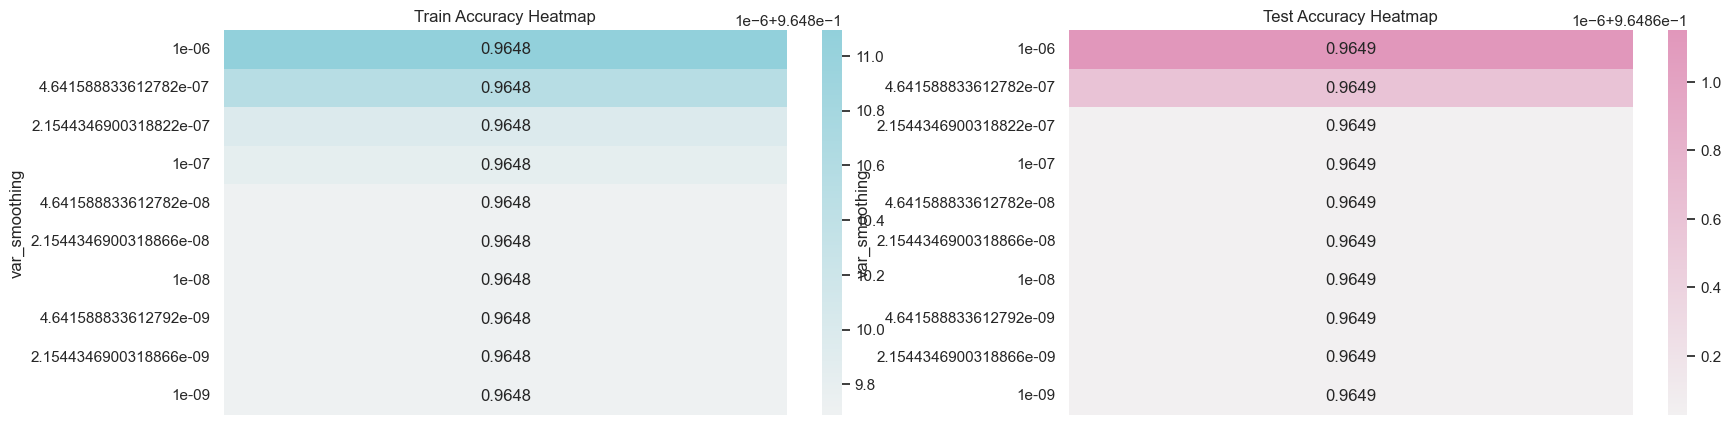

In [233]:
result_visualization(nb_clf_1, parameters, "accuracy", "var_smoothing")

Classification Report of Test Data for Model: GaussianNB
              precision    recall  f1-score   support

      attack    0.99201   0.96694   0.97931    665902
      normal    0.80506   0.94603   0.86987     96113

    accuracy                        0.96430    762015
   macro avg    0.89853   0.95648   0.92459    762015
weighted avg    0.96843   0.96430   0.96551    762015



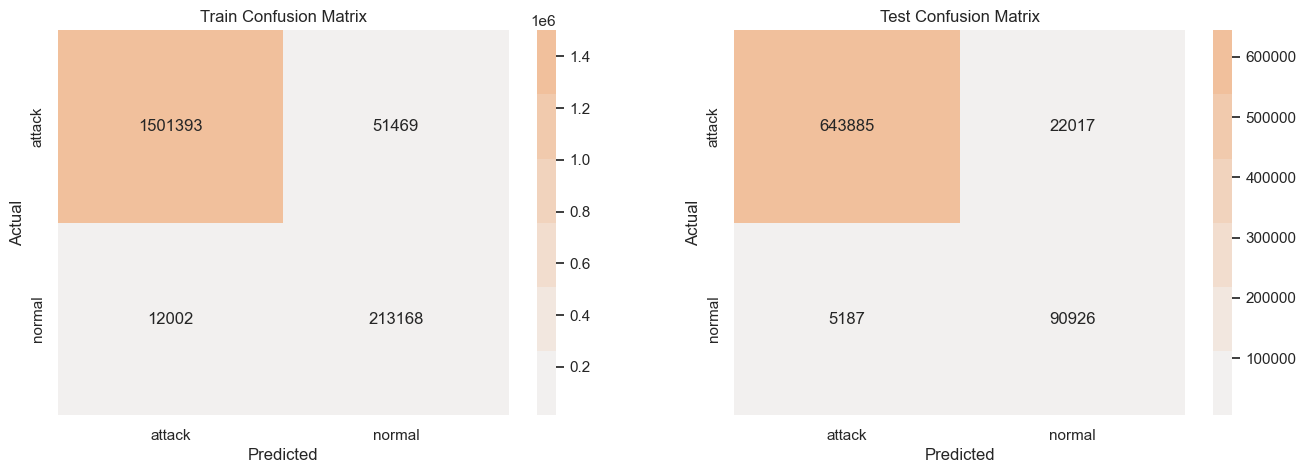

In [237]:
evaluate_model(nb_clf_1.best_estimator_, x_train_csr.toarray(), y_train, x_test_csr.toarray(), y_test, labels_binary)

##### Task 2: Multiclass classification

In [179]:
nb_clf_2 = GaussianNB()
parameters = {"var_smoothing": np.logspace(-6, -9, num=10)}
nb_clf_2 = tune_hyperparameters(nb_clf_2, parameters, x_train_csr.toarray(), y_train_multiclass)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END var_smoothing=1e-06; accuracy: (train=0.924, test=0.925) f1_weighted: (train=0.939, test=0.939) precision_weighted: (train=0.956, test=0.956) recall_weighted: (train=0.924, test=0.925) total time=   0.7s
[CV 2/5] END var_smoothing=1e-06; accuracy: (train=0.924, test=0.923) f1_weighted: (train=0.939, test=0.939) precision_weighted: (train=0.957, test=0.957) recall_weighted: (train=0.924, test=0.923) total time=   0.7s
[CV 3/5] END var_smoothing=1e-06; accuracy: (train=0.924, test=0.925) f1_weighted: (train=0.939, test=0.939) precision_weighted: (train=0.956, test=0.957) recall_weighted: (train=0.924, test=0.925) total time=   0.7s
[CV 4/5] END var_smoothing=1e-06; accuracy: (train=0.926, test=0.927) f1_weighted: (train=0.941, test=0.941) precision_weighted: (train=0.958, test=0.958) recall_weighted: (train=0.926, test=0.927) total time=   0.7s
[CV 5/5] END var_smoothing=1e-06; accuracy: (train=0.925, test=0.925) f

In [180]:
nb_clf_2.best_estimator_

GaussianNB(var_smoothing=1e-06)

Best Accuracy Score: 0.9246948321322351
Best Parameters: {'var_smoothing': 1e-06}


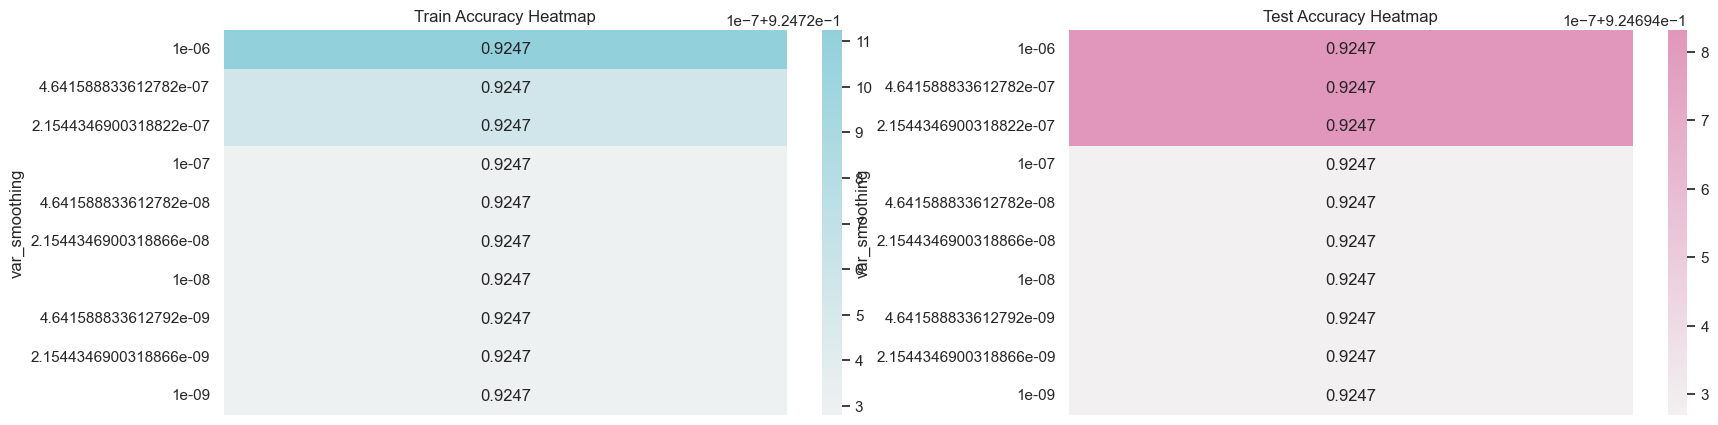

In [235]:
result_visualization(nb_clf_2, parameters, "accuracy", "var_smoothing")

Classification Report of Test Data for Model: GaussianNB
                precision    recall  f1-score   support

        normal    0.01188   0.06326   0.02001       822
       generic    0.03056   0.40533   0.05684       713
      exploits    0.07670   0.05813   0.06613      4920
       fuzzers    0.14475   0.20433   0.16946     13018
           dos    0.22736   0.45063   0.30223      7332
reconnaissance    0.91280   0.94132   0.92684     64575
      analysis    0.99938   0.95612   0.97727    665902
      backdoor    0.28065   0.22662   0.25075      4223
     shellcode    0.02517   0.06360   0.03607       456
         worms    0.00875   0.53704   0.01721        54

      accuracy                        0.92527    762015
     macro avg    0.27180   0.39064   0.28228    762015
  weighted avg    0.95745   0.92527   0.94027    762015



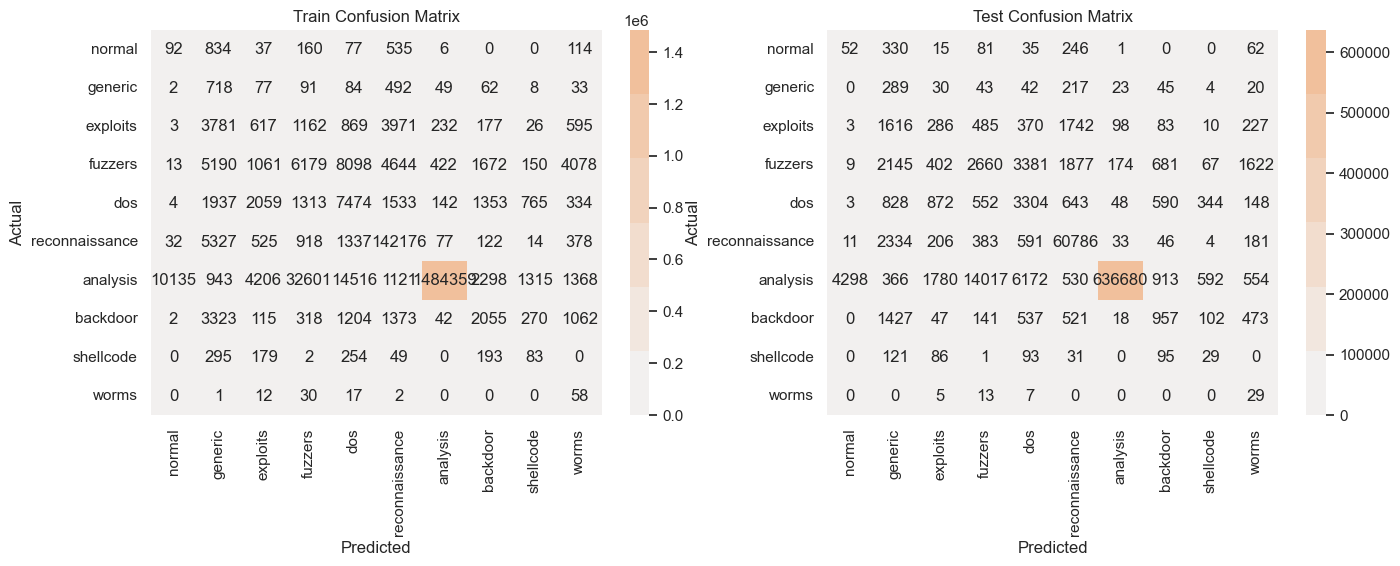

In [238]:
evaluate_model(nb_clf_2.best_estimator_, x_train_csr.toarray(), y_train_multiclass, x_test_csr.toarray(), y_test_multiclass, labels_multiclass)

### Support Vector Machine

##### Task 1: Binary classification

In [194]:
svc_clf_1 = SGDClassifier(loss="hinge")
parameters = {"alpha": np.logspace(-5, 2, num=8, base=10), "penalty": ["l1", "l2"]} 
svc_clf_1 = tune_hyperparameters(svc_clf_1, parameters, x_train_csr, y_train, cv=3)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END alpha=1e-05, penalty=l1; accuracy: (train=0.980, test=0.979) f1_weighted: (train=0.980, test=0.979) precision_weighted: (train=0.980, test=0.979) recall_weighted: (train=0.980, test=0.979) total time=   5.9s
[CV 2/3] END alpha=1e-05, penalty=l1; accuracy: (train=0.979, test=0.979) f1_weighted: (train=0.979, test=0.979) precision_weighted: (train=0.979, test=0.979) recall_weighted: (train=0.979, test=0.979) total time=   5.7s
[CV 3/3] END alpha=1e-05, penalty=l1; accuracy: (train=0.979, test=0.980) f1_weighted: (train=0.979, test=0.980) precision_weighted: (train=0.979, test=0.980) recall_weighted: (train=0.979, test=0.980) total time=   5.8s
[CV 1/3] END alpha=1e-05, penalty=l2; accuracy: (train=0.979, test=0.979) f1_weighted: (train=0.979, test=0.979) precision_weighted: (train=0.979, test=0.979) recall_weighted: (train=0.979, test=0.979) total time=   3.8s
[CV 2/3] END alpha=1e-05, penalty=l2; accuracy: (train=

In [195]:
svc_clf_1.best_estimator_

SGDClassifier(alpha=0.1)

Best Accuracy Score: 0.984720747552991
Best Parameters: {'alpha': 0.1, 'penalty': 'l2'}


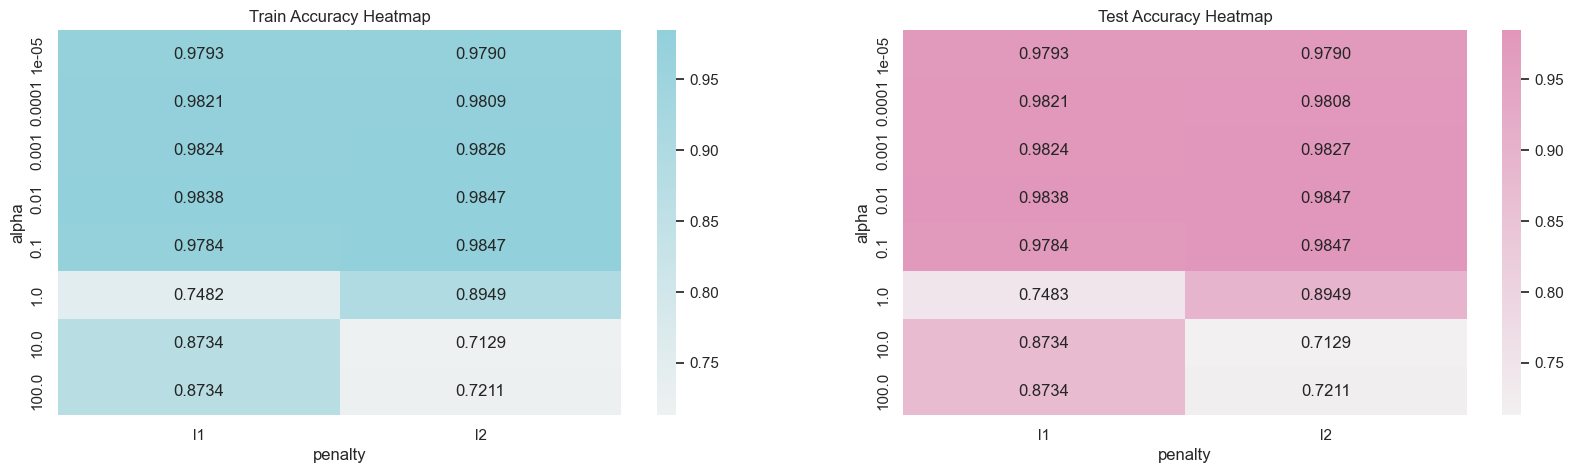

In [196]:
result_visualization(svc_clf_1, parameters, "accuracy", "alpha", "penalty")

Classification Report of Test Data for Model: SGDClassifier
              precision    recall  f1-score   support

      attack    1.00000   0.98271   0.99128    665902
      normal    0.89304   0.99998   0.94349     96113

    accuracy                        0.98489    762015
   macro avg    0.94652   0.99135   0.96739    762015
weighted avg    0.98651   0.98489   0.98525    762015



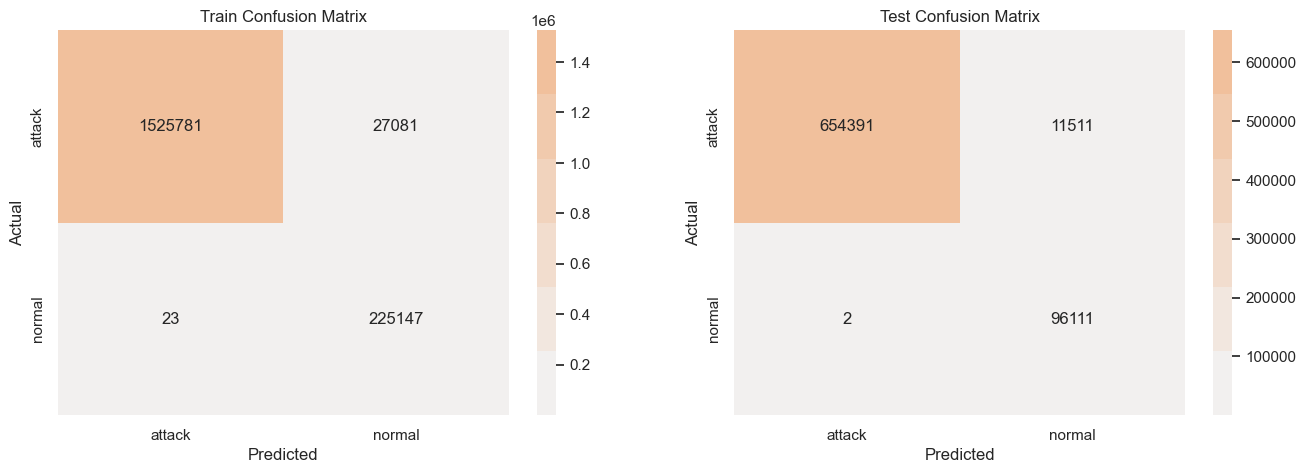

In [240]:
evaluate_model(svc_clf_1.best_estimator_, x_train_csr, y_train, x_test_csr, y_test, labels_binary)

##### Task 2: Multiclass classification

In [203]:
svc_clf_2 = SGDClassifier(loss="hinge")
parameters = {"alpha": np.logspace(-5, 2, num=8, base=10), "penalty": ["l1", "l2"]} 
svc_clf_2 = tune_hyperparameters(svc_clf_2, parameters, x_train_csr, y_train_multiclass, cv=3)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END alpha=1e-05, penalty=l1; accuracy: (train=0.957, test=0.956) f1_weighted: (train=0.951, test=0.950) precision_weighted: (train=0.946, test=0.945) recall_weighted: (train=0.957, test=0.956) total time=  38.5s
[CV 2/3] END alpha=1e-05, penalty=l1; accuracy: (train=0.956, test=0.957) f1_weighted: (train=0.950, test=0.950) precision_weighted: (train=0.945, test=0.945) recall_weighted: (train=0.956, test=0.957) total time=  36.6s
[CV 3/3] END alpha=1e-05, penalty=l1; accuracy: (train=0.956, test=0.956) f1_weighted: (train=0.951, test=0.951) precision_weighted: (train=0.947, test=0.947) recall_weighted: (train=0.956, test=0.956) total time=  37.2s
[CV 1/3] END alpha=1e-05, penalty=l2; accuracy: (train=0.957, test=0.956) f1_weighted: (train=0.951, test=0.951) precision_weighted: (train=0.946, test=0.946) recall_weighted: (train=0.957, test=0.956) total time=  21.9s
[CV 2/3] END alpha=1e-05, penalty=l2; accuracy: (train=

In [204]:
svc_clf_2.best_estimator_

SGDClassifier(penalty='l1')

Best Accuracy Score: 0.9582004147403794
Best Parameters: {'alpha': 0.0001, 'penalty': 'l1'}


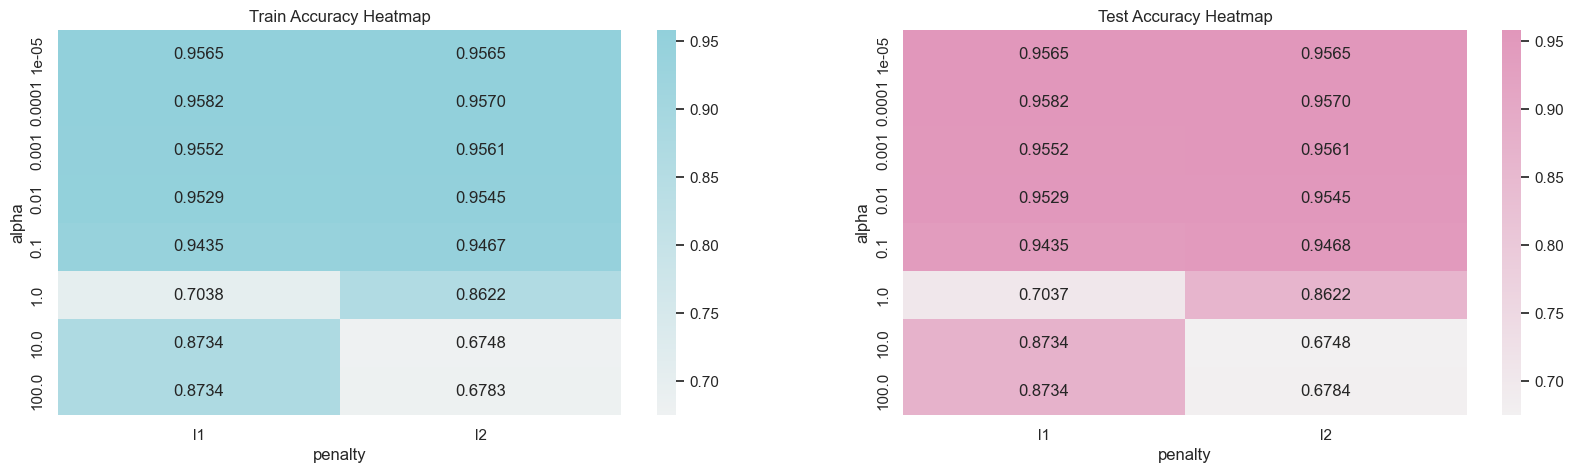

In [205]:
result_visualization(svc_clf_2, parameters, "accuracy", "alpha", "penalty")

Classification Report of Test Data for Model: SGDClassifier
                precision    recall  f1-score   support

        normal    0.61702   0.03528   0.06674       822
       generic    0.00000   0.00000   0.00000       713
      exploits    0.16142   0.02500   0.04329      4920
       fuzzers    0.40124   0.29790   0.34193     13018
           dos    0.33707   0.27032   0.30003      7332
reconnaissance    0.99710   0.97414   0.98549     64575
      analysis    0.97227   0.99140   0.98174    665902
      backdoor    0.38576   0.31305   0.34562      4223
     shellcode    0.00000   0.00000   0.00000       456
         worms    0.00000   0.00000   0.00000        54

      accuracy                        0.95853    762015
     macro avg    0.38719   0.29071   0.30648    762015
  weighted avg    0.94807   0.95853   0.95242    762015



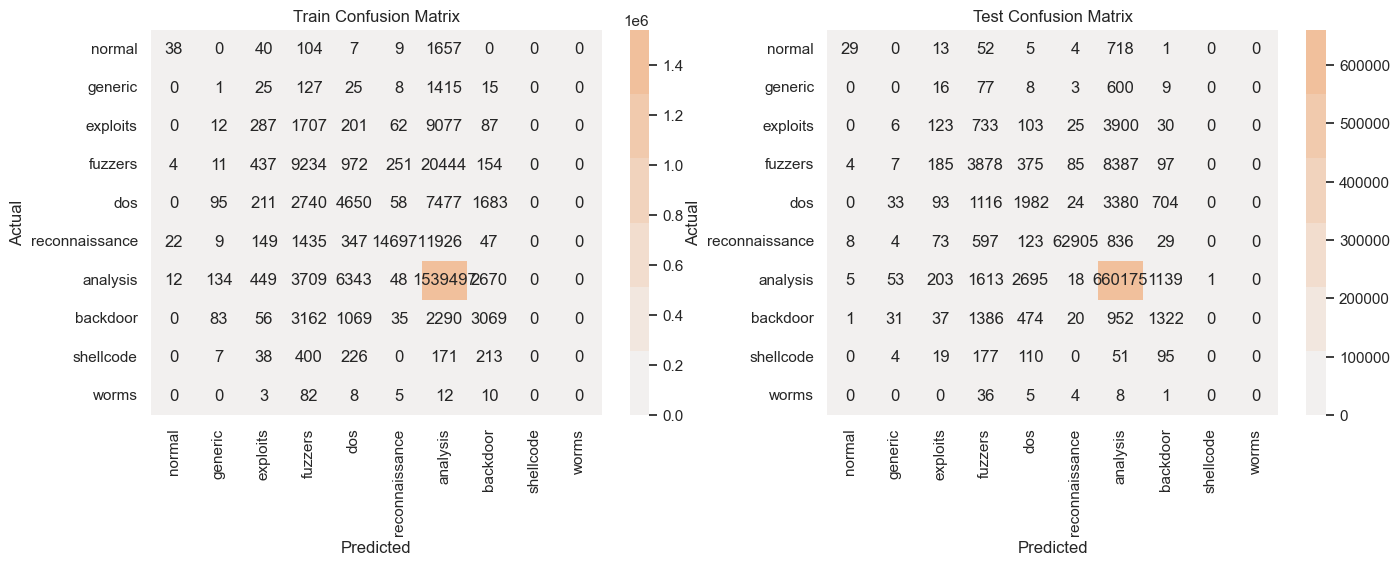

In [241]:
evaluate_model(svc_clf_2.best_estimator_, x_train_csr, y_train_multiclass, x_test_csr, y_test_multiclass, labels_multiclass)

### Logistic Regression

##### Task 1: Binary Classification

In [207]:
lr_clf_1 = SGDClassifier(loss="log_loss")
parameters = {"alpha":np.logspace(-6, 1, 8), "penalty": ["l1", "l2"]} 
lr_clf_1 = tune_hyperparameters(lr_clf_1, parameters, x_train_csr, y_train, cv=3)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END alpha=1e-06, penalty=l1; accuracy: (train=0.978, test=0.978) f1_weighted: (train=0.978, test=0.977) precision_weighted: (train=0.978, test=0.977) recall_weighted: (train=0.978, test=0.978) total time=  31.3s
[CV 2/3] END alpha=1e-06, penalty=l1; accuracy: (train=0.977, test=0.977) f1_weighted: (train=0.977, test=0.977) precision_weighted: (train=0.977, test=0.977) recall_weighted: (train=0.977, test=0.977) total time=  30.4s
[CV 3/3] END alpha=1e-06, penalty=l1; accuracy: (train=0.978, test=0.978) f1_weighted: (train=0.978, test=0.978) precision_weighted: (train=0.978, test=0.978) recall_weighted: (train=0.978, test=0.978) total time=  32.0s
[CV 1/3] END alpha=1e-06, penalty=l2; accuracy: (train=0.975, test=0.975) f1_weighted: (train=0.975, test=0.975) precision_weighted: (train=0.975, test=0.974) recall_weighted: (train=0.975, test=0.975) total time=  27.3s
[CV 2/3] END alpha=1e-06, penalty=l2; accuracy: (train=

In [208]:
lr_clf_1.best_estimator_

SGDClassifier(alpha=0.1, loss='log_loss')

Best Accuracy Score: 0.9841105223278522
Best Parameters: {'alpha': 0.1, 'penalty': 'l2'}


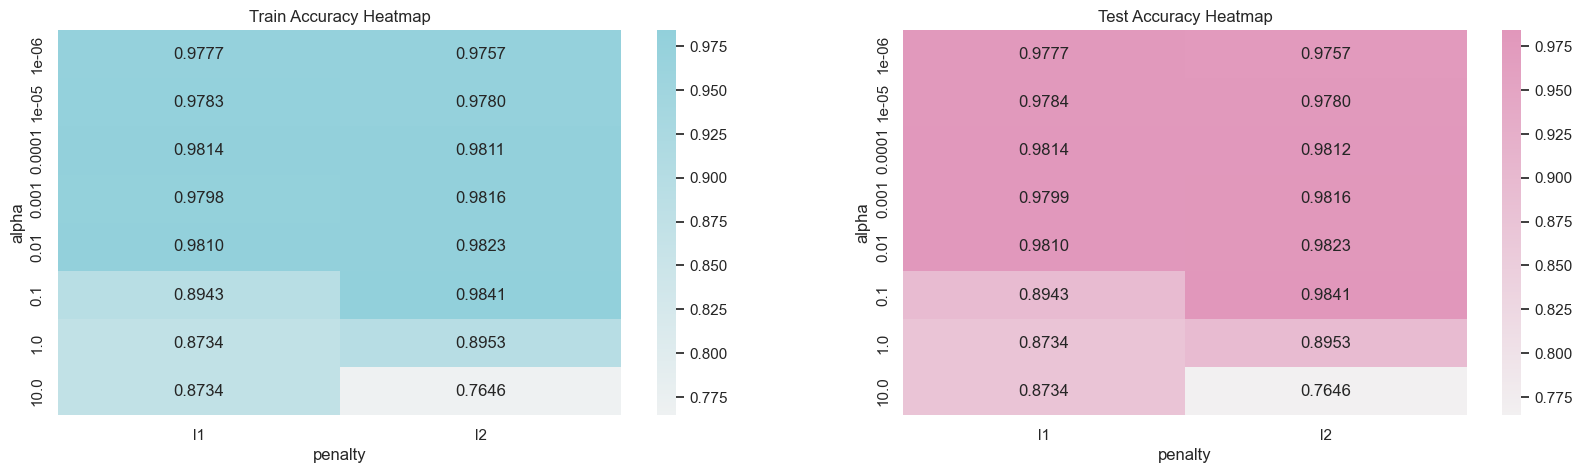

In [209]:
result_visualization(lr_clf_1, parameters, "accuracy", "alpha", "penalty")

Classification Report of Test Data for Model: SGDClassifier
              precision    recall  f1-score   support

      attack    0.99996   0.98221   0.99101    665902
      normal    0.89027   0.99975   0.94184     96113

    accuracy                        0.98443    762015
   macro avg    0.94511   0.99098   0.96642    762015
weighted avg    0.98613   0.98443   0.98481    762015



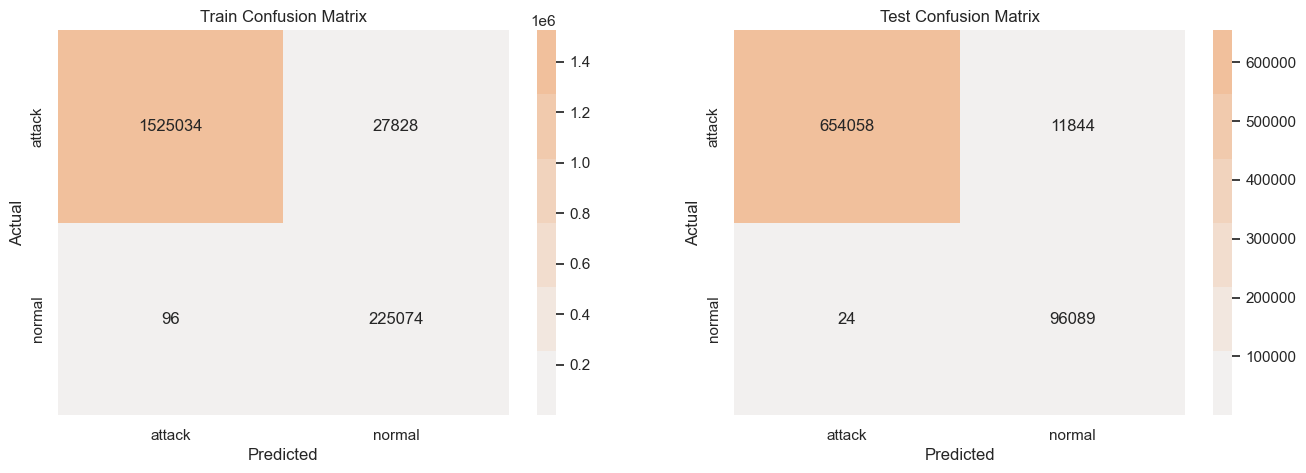

In [262]:
evaluate_model(lr_clf_1.best_estimator_, x_train_csr, y_train, x_test_csr, y_test, labels_binary)

##### Task 2: Multiclass Classification

In [211]:
lr_clf_2 = SGDClassifier(loss="log_loss")
parameters = {"alpha":np.logspace(-6, 1, 8), "penalty": ["l1", "l2"]} 
lr_clf_2 = tune_hyperparameters(lr_clf_2, parameters, x_train_csr, y_train_multiclass, cv=3)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END alpha=1e-06, penalty=l1; accuracy: (train=0.956, test=0.956) f1_weighted: (train=0.950, test=0.949) precision_weighted: (train=0.945, test=0.944) recall_weighted: (train=0.956, test=0.956) total time= 2.2min
[CV 2/3] END alpha=1e-06, penalty=l1; accuracy: (train=0.956, test=0.956) f1_weighted: (train=0.950, test=0.950) precision_weighted: (train=0.945, test=0.945) recall_weighted: (train=0.956, test=0.956) total time= 2.1min
[CV 3/3] END alpha=1e-06, penalty=l1; accuracy: (train=0.956, test=0.956) f1_weighted: (train=0.951, test=0.950) precision_weighted: (train=0.946, test=0.946) recall_weighted: (train=0.956, test=0.956) total time= 2.0min
[CV 1/3] END alpha=1e-06, penalty=l2; accuracy: (train=0.957, test=0.956) f1_weighted: (train=0.951, test=0.950) precision_weighted: (train=0.945, test=0.945) recall_weighted: (train=0.957, test=0.956) total time= 1.7min
[CV 2/3] END alpha=1e-06, penalty=l2; accuracy: (train=

In [212]:
lr_clf_2.best_estimator_

SGDClassifier(alpha=1e-06, loss='log_loss')

Best Accuracy Score: 0.9566087676179871
Best Parameters: {'alpha': 1e-06, 'penalty': 'l2'}


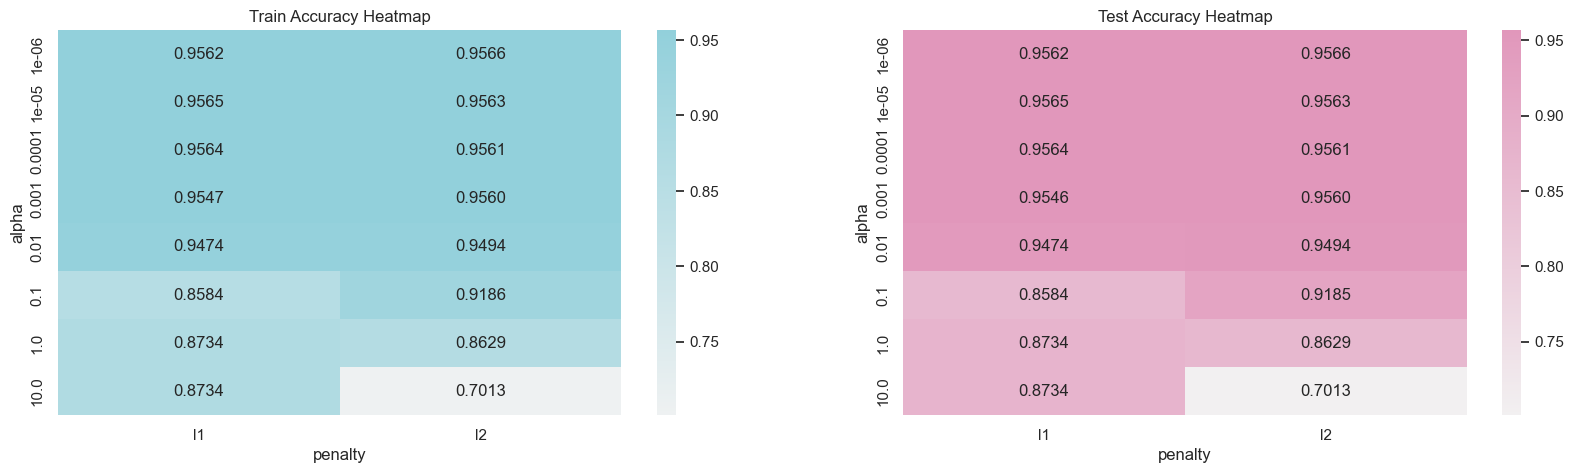

In [213]:
result_visualization(lr_clf_2, parameters, "accuracy", "alpha", "penalty")

Classification Report of Test Data for Model: SGDClassifier
                precision    recall  f1-score   support

        normal    0.46154   0.01460   0.02830       822
       generic    0.01333   0.00140   0.00254       713
      exploits    0.13499   0.02541   0.04276      4920
       fuzzers    0.32321   0.30158   0.31202     13018
           dos    0.35604   0.11688   0.17599      7332
reconnaissance    0.99395   0.97499   0.98438     64575
      analysis    0.97231   0.99046   0.98130    665902
      backdoor    0.25709   0.28960   0.27238      4223
     shellcode    0.00000   0.00000   0.00000       456
         worms    0.00000   0.00000   0.00000        54

      accuracy                        0.95622    762015
     macro avg    0.35125   0.27149   0.27997    762015
  weighted avg    0.94565   0.95622   0.94979    762015



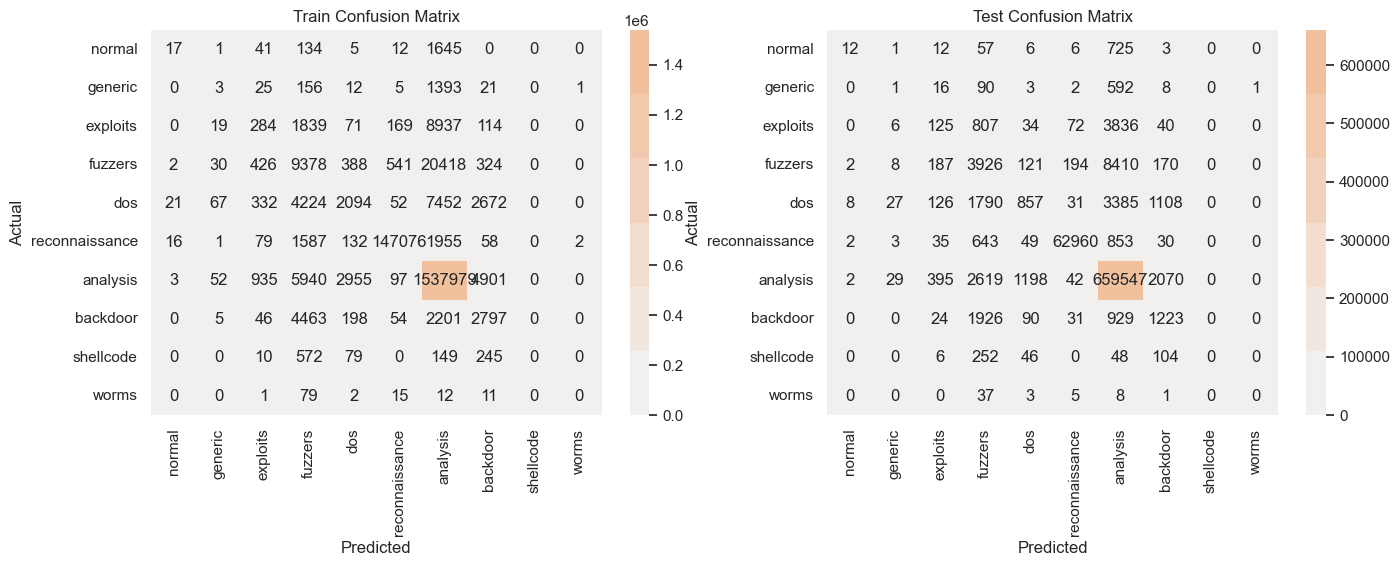

In [263]:
evaluate_model(lr_clf_2.best_estimator_, x_train_csr, y_train_multiclass, x_test_csr, y_test_multiclass, labels_multiclass)

### Random Forest

##### Task 1: Binary Classification

In [25]:
rf_clf_1 = RandomForestClassifier()
parameters = {"n_estimators":[200, 300], "max_depth": [20, 22]}
rf_clf_1 = tune_hyperparameters(rf_clf_1, parameters, x_train_robust_csr, y_train, cv=2)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END max_depth=20, n_estimators=200; accuracy: (train=0.995, test=0.987) f1_weighted: (train=0.995, test=0.988) precision_weighted: (train=0.995, test=0.988) recall_weighted: (train=0.995, test=0.987) total time= 3.4min
[CV 2/2] END max_depth=20, n_estimators=200; accuracy: (train=0.995, test=0.988) f1_weighted: (train=0.995, test=0.988) precision_weighted: (train=0.995, test=0.988) recall_weighted: (train=0.995, test=0.988) total time= 3.4min
[CV 1/2] END max_depth=20, n_estimators=300; accuracy: (train=0.995, test=0.987) f1_weighted: (train=0.995, test=0.988) precision_weighted: (train=0.995, test=0.988) recall_weighted: (train=0.995, test=0.987) total time= 5.0min
[CV 2/2] END max_depth=20, n_estimators=300; accuracy: (train=0.995, test=0.988) f1_weighted: (train=0.995, test=0.988) precision_weighted: (train=0.995, test=0.988) recall_weighted: (train=0.995, test=0.988) total time= 5.1min
[CV 1/2] END max_depth=22, n_

In [26]:
rf_clf_1.best_estimator_

RandomForestClassifier(max_depth=20, n_estimators=300)

Best Accuracy Score: 0.9875508427294897
Best Parameters: {'max_depth': 20, 'n_estimators': 300}


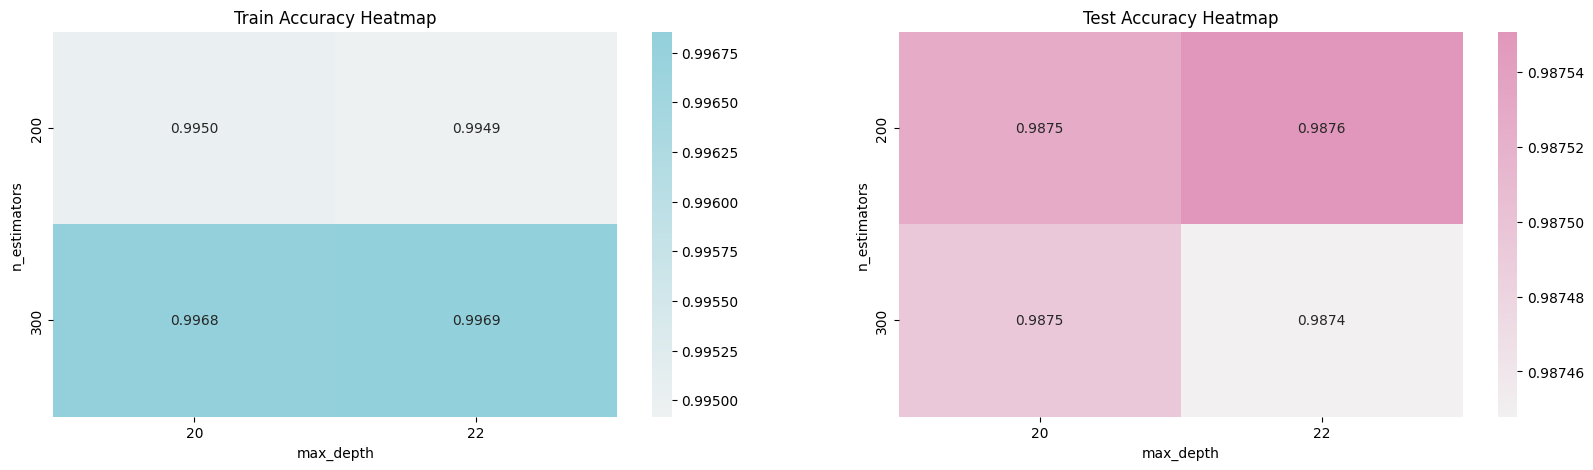

In [27]:
result_visualization(rf_clf_1.best_estimator_, parameters, "accuracy", "n_estimators", "max_depth")

Classification Report of Test Data for Model: RandomForestClassifier
              precision    recall  f1-score   support

      attack    0.99758   0.98866   0.99310    665902
      normal    0.92600   0.98340   0.95384     96113

    accuracy                        0.98799    762015
   macro avg    0.96179   0.98603   0.97347    762015
weighted avg    0.98855   0.98799   0.98815    762015



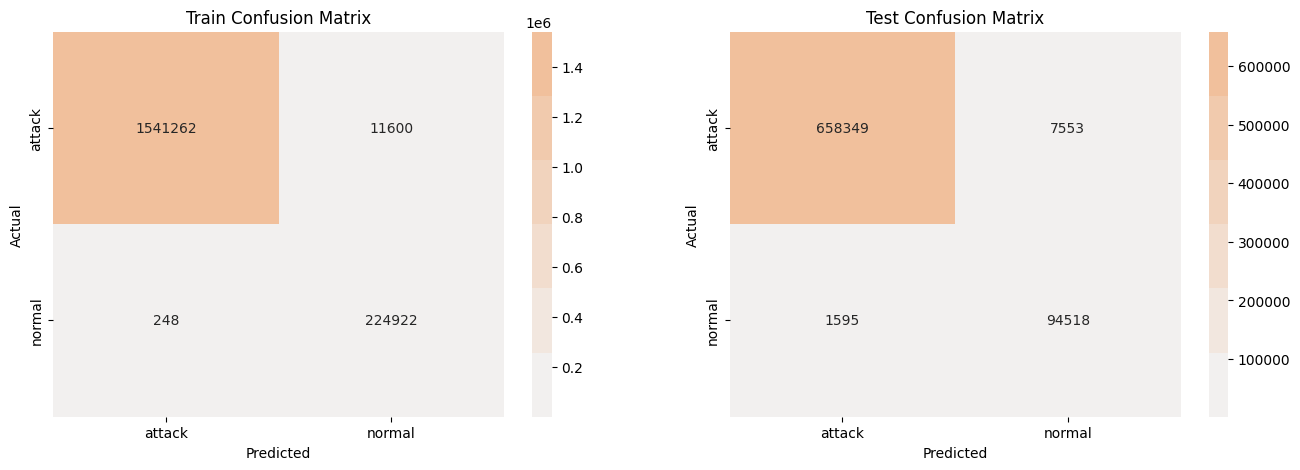

In [46]:
evaluate_model(rf_clf_1, x_train_robust_csr, y_train, x_test_robust_csr, y_test, labels_binary)

Classification Report of Test Data for Model: RandomForestClassifier
              precision    recall  f1-score   support

      normal    0.99755   0.98870   0.99310    665902
      attack    0.92622   0.98314   0.95383     96113

    accuracy                        0.98800    762015
   macro avg    0.96188   0.98592   0.97347    762015
weighted avg    0.98855   0.98800   0.98815    762015



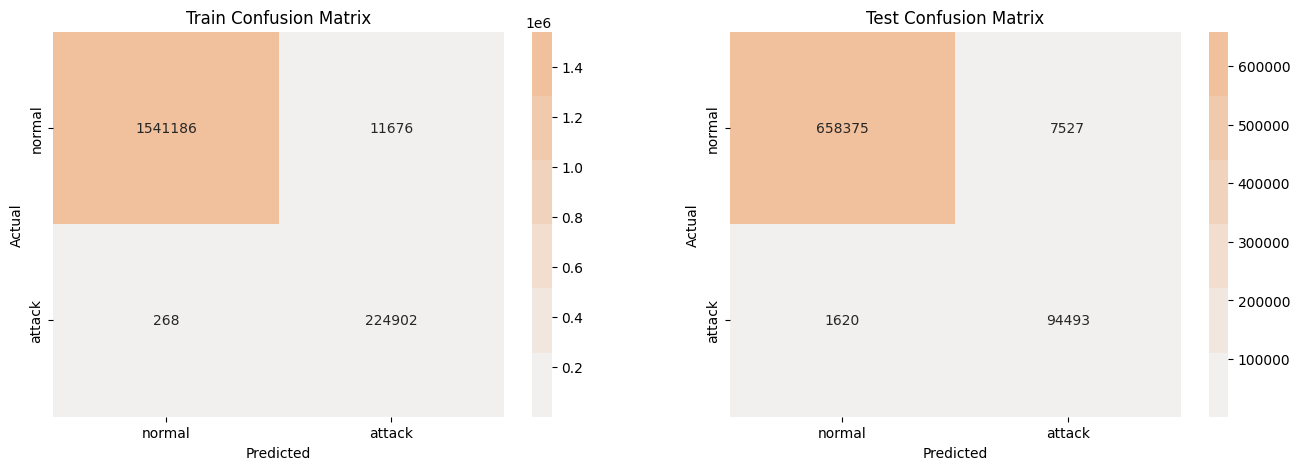

In [69]:
evaluate_model(rf_clf_1, x_train_robust_csr, y_train, x_test_robust_csr, y_test, labels_binary)

##### Task 2: Multiclass Classification

In [48]:
rf_clf_2 = RandomForestClassifier()
parameters = {"n_estimators":[200, 300], "max_depth": [20, 22]}
rf_clf_2 = tune_hyperparameters(rf_clf_1, parameters, x_train_robust_csr, y_train_multiclass, cv=2)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END max_depth=20, n_estimators=200; accuracy: (train=0.984, test=0.969) f1_weighted: (train=0.983, test=0.967) precision_weighted: (train=0.985, test=0.967) recall_weighted: (train=0.984, test=0.969) total time= 6.0min
[CV 2/2] END max_depth=20, n_estimators=200; accuracy: (train=0.984, test=0.969) f1_weighted: (train=0.983, test=0.967) precision_weighted: (train=0.984, test=0.966) recall_weighted: (train=0.984, test=0.969) total time= 5.9min
[CV 1/2] END max_depth=20, n_estimators=300; accuracy: (train=0.984, test=0.969) f1_weighted: (train=0.983, test=0.967) precision_weighted: (train=0.984, test=0.966) recall_weighted: (train=0.984, test=0.969) total time= 8.7min
[CV 2/2] END max_depth=20, n_estimators=300; accuracy: (train=0.984, test=0.969) f1_weighted: (train=0.983, test=0.967) precision_weighted: (train=0.984, test=0.966) recall_weighted: (train=0.984, test=0.969) total time= 9.0min
[CV 1/2] END max_depth=22, n_

In [49]:
rf_clf_2.best_estimator_

RandomForestClassifier(max_depth=20, n_estimators=200)

In [219]:
rf_clf_2 = RandomForestClassifier(n_estimators=300, max_depth=22)

Best Accuracy Score: 0.9691293520026636
Best Parameters: {'max_depth': 20, 'n_estimators': 200}


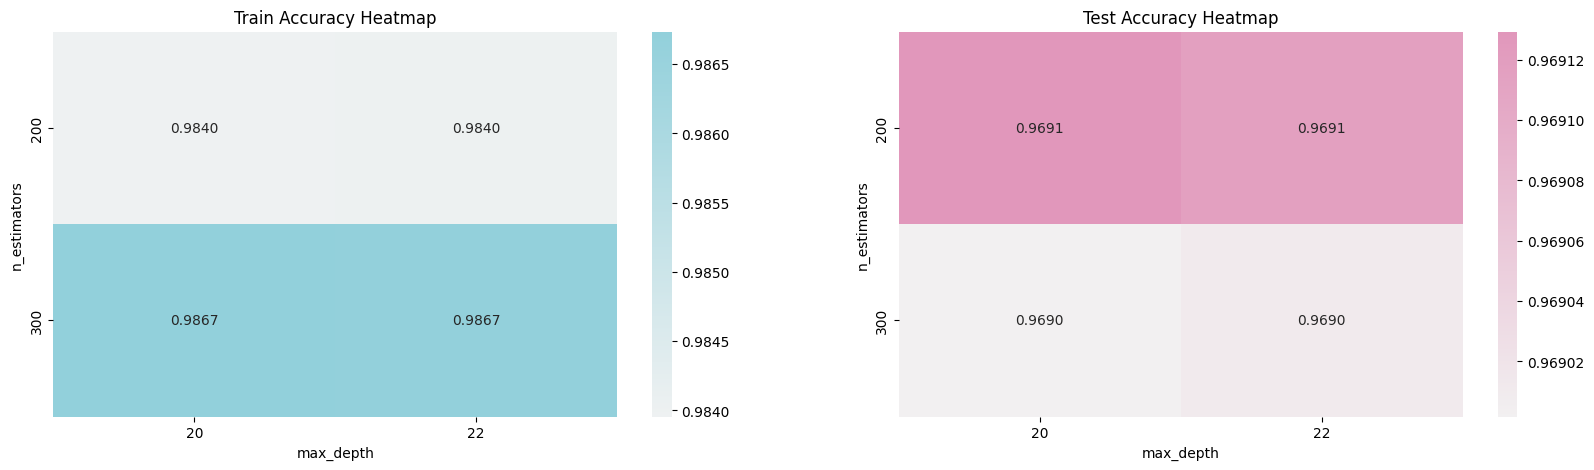

In [50]:
result_visualization(rf_clf_2, parameters, "accuracy", "n_estimators", "max_depth")

Classification Report of Test Data for Model: RandomForestClassifier
                precision    recall  f1-score   support

      analysis    0.70370   0.02311   0.04476       822
      backdoor    0.11111   0.00140   0.00277       713
           dos    0.28588   0.14817   0.19518      4920
      exploits    0.50517   0.72023   0.59383     13018
       fuzzers    0.42042   0.28751   0.34149      7332
       generic    0.99649   0.97285   0.98453     64575
        normal    0.98841   0.99528   0.99183    665902
reconnaissance    0.66013   0.33483   0.44430      4223
     shellcode    0.48905   0.14693   0.22597       456
         worms    0.00000   0.00000   0.00000        54

      accuracy                        0.97019    762015
     macro avg    0.51604   0.36303   0.38247    762015
  weighted avg    0.96752   0.97019   0.96750    762015



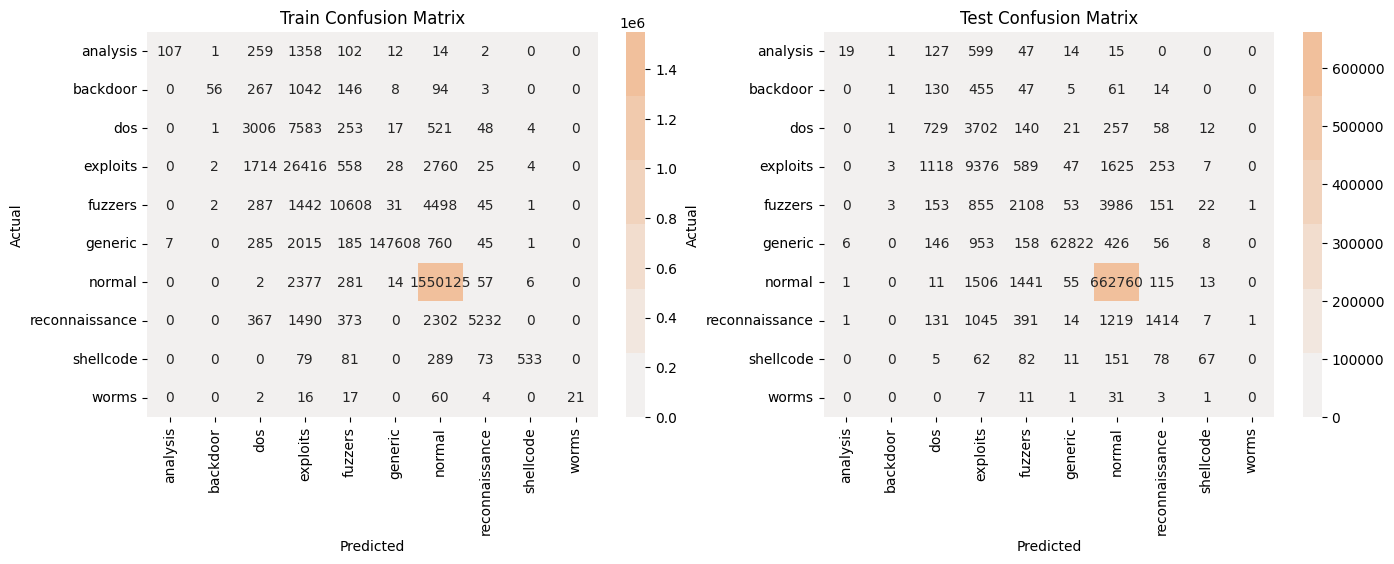

In [68]:
evaluate_model(rf_clf_2.best_estimator_, x_train_robust_csr, y_train_multiclass, x_test_robust_csr, y_test_multiclass, labels_multiclass)

## Unsupervised models

### K-Means

##### Task 1: Binary Classification

In [70]:
kmeans_clf1 = KMeans(n_clusters=2, random_state=42, init="k-means++")

Classification Report of Test Data for Model: KMeans
              precision    recall  f1-score   support

           0    0.89301   0.98660   0.93748    665902
           1    0.66106   0.18105   0.28425     96113

    accuracy                        0.88500    762015
   macro avg    0.77703   0.58382   0.61086    762015
weighted avg    0.86375   0.88500   0.85508    762015



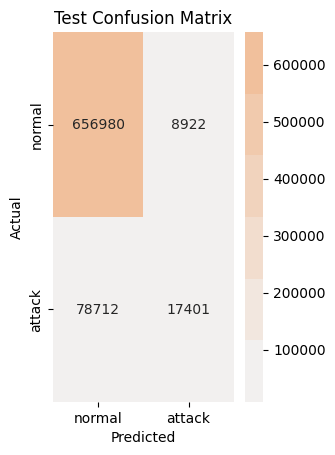

In [71]:
evaluate_model_not_supervised(kmeans_clf1, x_train_csr, x_test_csr, y_test, labels_binary)

##### Task 2: Multiclass Classification

In [72]:
kmeans_clf2 = KMeans(n_clusters=10, random_state=42, init="k-means++")

Classification Report of Test Data for Model: KMeans
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000       822
           1    0.00000   0.00000   0.00000       713
           2    0.00000   0.00000   0.00000      4920
           3    0.00000   0.00000   0.00000     13018
           4    0.00000   0.00000   0.00000      7332
           5    0.00000   0.00000   0.00000     64575
           6    0.87387   1.00000   0.93269    665902
           7    0.00000   0.00000   0.00000      4223
           8    0.00000   0.00000   0.00000       456
           9    0.00000   0.00000   0.00000        54

    accuracy                        0.87387    762015
   macro avg    0.08739   0.10000   0.09327    762015
weighted avg    0.76365   0.87387   0.81505    762015



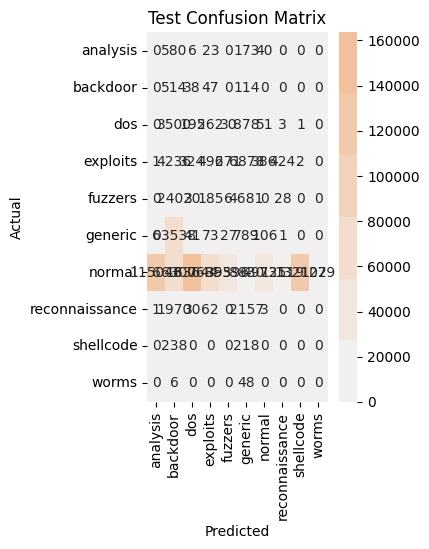

In [73]:
evaluate_model_not_supervised(kmeans_clf2, x_train_csr, x_test_csr, y_test_multiclass, labels_multiclass)

### DBSCAN

##### Task 1: Binary Classification

In [12]:
x_test_sample, _, y_test_sample, _ = train_test_split(x_test_robust_csr, y_test, test_size=0.9, random_state=42)

In [13]:
x_test_sample.shape, y_test_sample.shape

((76201, 3), (76201,))

In [15]:
dbscan_clf_1 = DBSCAN(eps=0.7, min_samples=100, n_jobs=4)

Classification Report of Test Data for Model: DBSCAN
              precision    recall  f1-score   support

           0    0.99982   0.99612   0.99796     65126
           1    0.96845   0.99846   0.98322      7778

    accuracy                        0.99637     72904
   macro avg    0.98413   0.99729   0.99059     72904
weighted avg    0.99647   0.99637   0.99639     72904



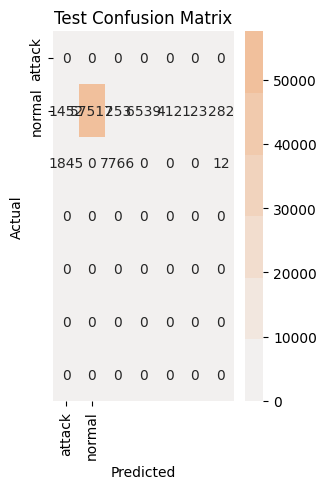

In [16]:
evaluate_model_not_supervised(dbscan_clf_1, [], x_test_sample, y_test_sample, labels_binary)

##### Task 2: Multiclass Classification

In [17]:
x_test_sample, _, y_test_multiclass_sample, _ = train_test_split(x_test_robust_csr, y_test_multiclass, test_size=0.9, random_state=42)

In [18]:
x_test_sample.shape, y_test_multiclass_sample.shape

((76201, 3), (76201,))

In [19]:
dbscan_clf_2 = DBSCAN(eps=0.7, min_samples=100, n_jobs=4) 

Classification Report of Test Data for Model: DBSCAN
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000        58
           1    0.00000   0.00000   0.00000        55
           2    0.00000   0.00000   0.00000       356
           3    0.00000   0.00000   0.00000       472
           4    0.00000   0.00000   0.00000       264
           5    0.79299   0.99984   0.88448      6360
           6    0.99982   0.99612   0.99796     65126
           7    0.00000   0.00000   0.00000       186
           8    0.00000   0.00000   0.00000        27

    accuracy                        0.97707     72904
   macro avg    0.19920   0.22177   0.20916     72904
weighted avg    0.96233   0.97707   0.96865     72904



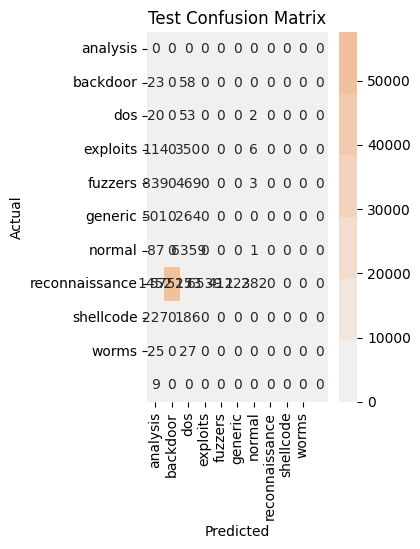

In [74]:
evaluate_model_not_supervised(dbscan_clf_2, [], x_test_sample, y_test_multiclass_sample, labels_multiclass)

## Deep learning models

### DBN

##### Task 1: Binary Classification

In [15]:
rbm1 = BernoulliRBM(n_components=256, learning_rate=0.01, n_iter=20, random_state=42)
rbm2 = BernoulliRBM(n_components=128, learning_rate=0.01, n_iter=20, random_state=42)
classifier = LogisticRegression()

dbn_clf_1 = Pipeline(steps=[("rbm1", rbm1), ("rbm2", rbm2), ("classifier", classifier)])

Classification Report of Test Data for Model: Pipeline
              precision    recall  f1-score   support

      attack    0.99974   0.98157   0.99057    665902
      normal    0.88660   0.99821   0.93910     96113

    accuracy                        0.98367    762015
   macro avg    0.94317   0.98989   0.96484    762015
weighted avg    0.98547   0.98367   0.98408    762015



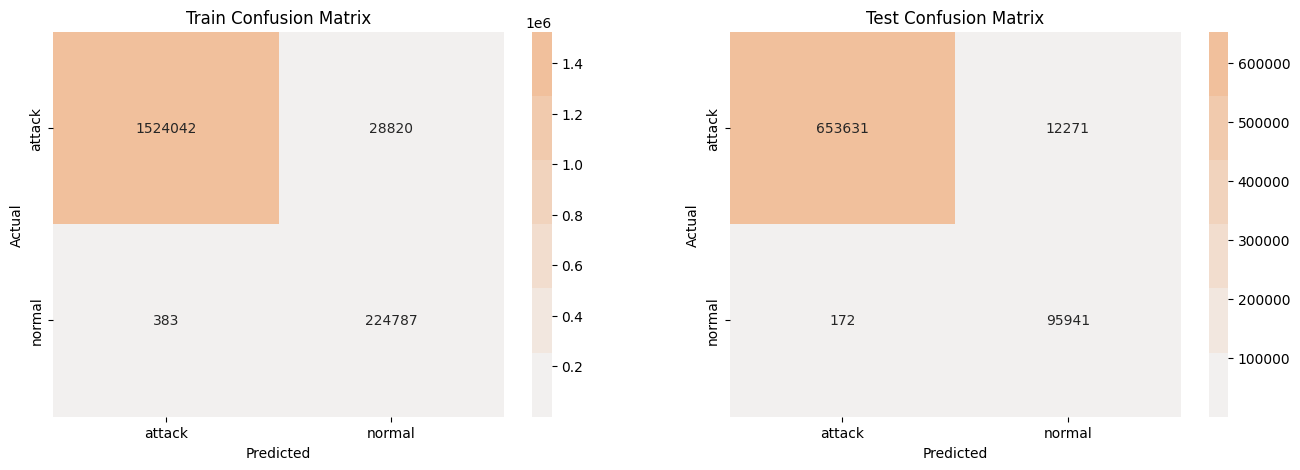

In [16]:
evaluate_model(dbn_clf_1, x_train_robust_csr, y_train, x_test_robust_csr, y_test, labels_binary)

##### Task 2: Multiclass Classification

In [17]:
dbn_clf_2 = Pipeline(steps=[("rbm1", rbm1), ("rbm2", rbm2), ("classifier", classifier)])

Classification Report of Test Data for Model: Pipeline
                precision    recall  f1-score   support

        normal    0.00000   0.00000   0.00000       822
       generic    0.00000   0.00000   0.00000       713
      exploits    0.00000   0.00000   0.00000      4920
       fuzzers    0.00000   0.00000   0.00000     13018
           dos    0.00000   0.00000   0.00000      7332
reconnaissance    0.00000   0.00000   0.00000     64575
      analysis    0.87387   1.00000   0.93269    665902
      backdoor    0.00000   0.00000   0.00000      4223
     shellcode    0.00000   0.00000   0.00000       456
         worms    0.00000   0.00000   0.00000        54

      accuracy                        0.87387    762015
     macro avg    0.08739   0.10000   0.09327    762015
  weighted avg    0.76365   0.87387   0.81505    762015



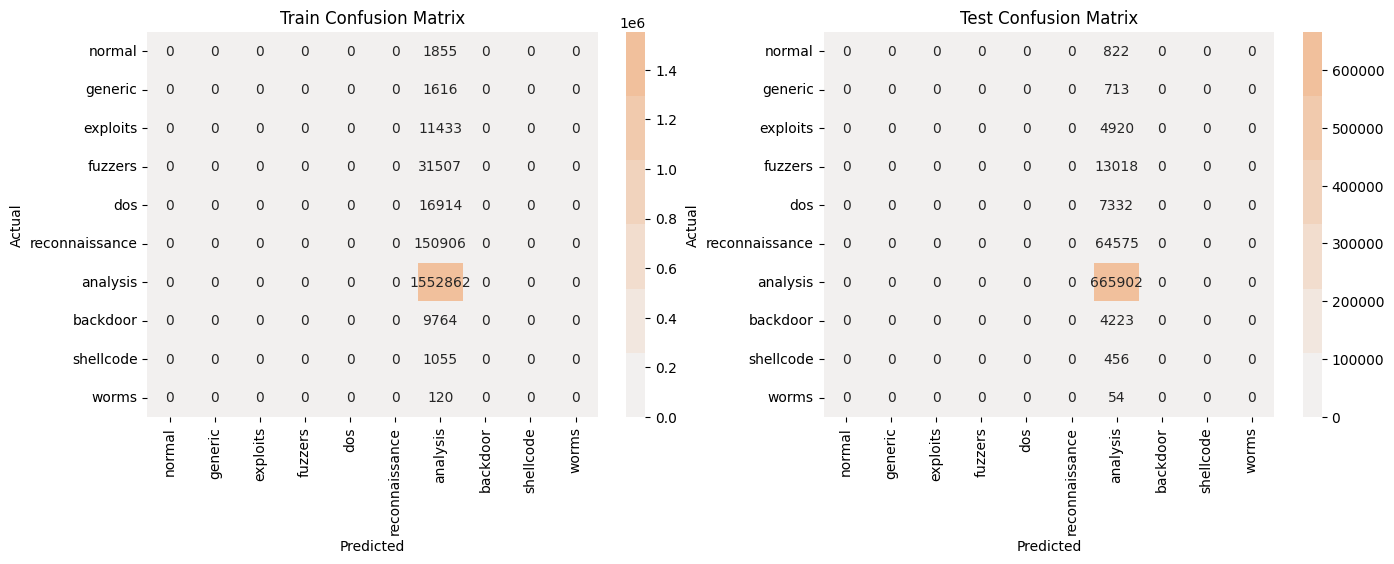

In [18]:
evaluate_model(dbn_clf_2, x_train_csr, y_train_multiclass, x_test_csr, y_test_multiclass, labels_multiclass)

### CNN-LSTM

##### Task 1: Binary Classification

In [19]:
cnn_lstm_1 = Sequential([
    Conv1D(64, kernel_size=3, activation="relu", input_shape=(x_train_robust_no_pca.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation="relu", return_sequences=False),
    Dense(1, activation="sigmoid")  # Binary output
])

cnn_lstm_1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Configurar ModelCheckpoint para guardar el mejor modelo basado en la métrica de validación
checkpoint = ModelCheckpoint("best_cnn_lstm_1.keras", monitor="val_loss", save_best_only=True, mode="min")

# Entrenar el modelo con el callback
cnn_lstm_1_history = cnn_lstm_1.fit(
    x_train_robust_no_pca.toarray(), y_train, 
    epochs=5, batch_size=64, 
    validation_split=0.2, 
    callbacks=[checkpoint]
)

Epoch 1/5
22226/22226 ━━━━━━━━━━━━━━━━━━━━ 787s 35ms/step - accuracy: 0.9388 - loss: 10.4823 - val_accuracy: 0.9846 - val_loss: 0.0428
Epoch 2/5
22226/22226 ━━━━━━━━━━━━━━━━━━━━ 791s 36ms/step - accuracy: 0.9745 - loss: 78179232.0000 - val_accuracy: 0.5342 - val_loss: 1084561.0000
Epoch 3/5
22226/22226 ━━━━━━━━━━━━━━━━━━━━ 764s 34ms/step - accuracy: 0.6158 - loss: 4527155200.0000 - val_accuracy: 0.8899 - val_loss: 3576.6560
Epoch 4/5
22226/22226 ━━━━━━━━━━━━━━━━━━━━ 749s 34ms/step - accuracy: 0.8397 - loss: 856836.3125 - val_accuracy: 0.8825 - val_loss: 951.0547
Epoch 5/5
22226/22226 ━━━━━━━━━━━━━━━━━━━━ 752s 34ms/step - accuracy: 0.6976 - loss: 1064179.2500 - val_accuracy: 0.9750 - val_loss: 17.0400


In [27]:
best_model = load_model("best_cnn_lstm_1.keras")
y_pred_prob = best_model.predict(x_test_robust_no_pca.toarray())
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=5))

23813/23813 ━━━━━━━━━━━━━━━━━━━━ 123s 5ms/step
              precision    recall  f1-score   support

           0    0.99938   0.98313   0.99118    665902
           1    0.89492   0.99574   0.94265     96113

    accuracy                        0.98472    762015
   macro avg    0.94715   0.98943   0.96691    762015
weighted avg    0.98620   0.98472   0.98506    762015



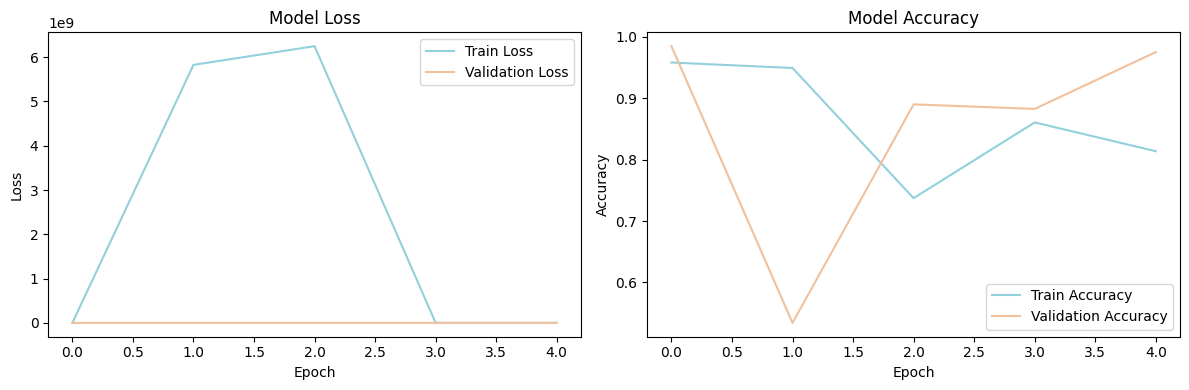

In [20]:
# Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_lstm_1_history.history["loss"], label="Train Loss", color="#92d0db")
plt.plot(cnn_lstm_1_history.history["val_loss"], label="Validation Loss", color="#f1c09c")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_lstm_1_history.history["accuracy"], label="Train Accuracy", color="#92d0db")
plt.plot(cnn_lstm_1_history.history["val_accuracy"], label="Validation Accuracy", color="#f1c09c")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

##### Task 2: Multiclass Classification

In [13]:
# Convert labels to One-Hot Encoding format
y_train_multiclass_one_hot = to_categorical(y_train_multiclass, num_classes=10)
y_test_multiclass_one_hot = to_categorical(y_test_multiclass, num_classes=10)

cnn_lstm_2 = Sequential([
    Conv1D(64, kernel_size=3, activation="relu", input_shape=(x_train_robust_no_pca.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation="relu", return_sequences=False),
    Dense(10, activation="softmax")  # Multiclass output
])

cnn_lstm_2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

checkpoint = ModelCheckpoint("best_cnn_lstm_2.keras", monitor="val_loss", save_best_only=True, mode="min")

cnn_lstm_2_history = cnn_lstm_2.fit(
    x_train_robust_no_pca.toarray(), y_train_multiclass_one_hot, 
    epochs=5, batch_size=64, 
    validation_split=0.2, 
    callbacks=[checkpoint]
)
y_pred_prob = cnn_lstm_2.predict(x_test_robust_no_pca.toarray())
y_pred = np.argmax(y_pred_prob, axis=1)
y_test = np.argmax(y_test_multiclass_one_hot, axis=1)

print(classification_report(y_test, y_pred))

Epoch 1/5
22226/22226 ━━━━━━━━━━━━━━━━━━━━ 767s 34ms/step - accuracy: 0.6535 - loss: 61004008.0000 - val_accuracy: 0.7600 - val_loss: 1633153.3750
Epoch 2/5
22226/22226 ━━━━━━━━━━━━━━━━━━━━ 773s 35ms/step - accuracy: 0.3479 - loss: 529470880.0000 - val_accuracy: 0.0846 - val_loss: 69745.9297
Epoch 3/5
22226/22226 ━━━━━━━━━━━━━━━━━━━━ 1121s 50ms/step - accuracy: 0.7274 - loss: 2453744.2500 - val_accuracy: 0.8736 - val_loss: 7.0498
Epoch 4/5
22226/22226 ━━━━━━━━━━━━━━━━━━━━ 829s 37ms/step - accuracy: 0.9282 - loss: 2462556.2500 - val_accuracy: 0.9524 - val_loss: 0.7066
Epoch 5/5
22226/22226 ━━━━━━━━━━━━━━━━━━━━ 813s 37ms/step - accuracy: 0.9514 - loss: 0.4624 - val_accuracy: 0.9471 - val_loss: 0.2665
23813/23813 ━━━━━━━━━━━━━━━━━━━━ 123s 5ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       822
           1       0.00      0.00      0.00       713
           2       0.00      0.00      0.00      4920
           3       0.20     

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [17]:
best_model = load_model("best_cnn_lstm_2.keras")
y_pred_prob = best_model.predict(x_test_robust_no_pca.toarray())

y_pred = np.argmax(y_pred_prob, axis=1)
y_test = np.argmax(y_test_multiclass_one_hot, axis=1)

print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000       822
           1    0.00000   0.00000   0.00000       713
           2    0.00000   0.00000   0.00000      4920
           3    0.19620   0.43440   0.27032     13018
           4    0.00000   0.00000   0.00000      7332
           5    0.94286   0.85496   0.89676     64575
           6    0.97980   0.99249   0.98611    665902
           7    0.02273   0.00024   0.00047      4223
           8    0.00000   0.00000   0.00000       456
           9    0.00000   0.00000   0.00000        54

    accuracy                        0.94718    762015
   macro avg    0.21416   0.22821   0.21537    762015
weighted avg    0.93960   0.94718   0.94234    762015



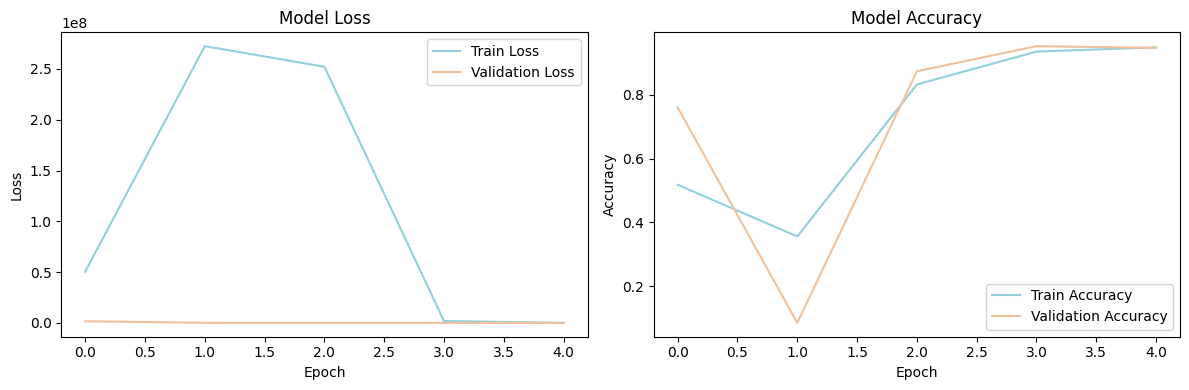

In [14]:
# Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_lstm_2_history.history["loss"], label="Train Loss", color="#92d0db")
plt.plot(cnn_lstm_2_history.history["val_loss"], label="Validation Loss", color="#f1c09c")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_lstm_2_history.history["accuracy"], label="Train Accuracy", color="#92d0db")
plt.plot(cnn_lstm_2_history.history["val_accuracy"], label="Validation Accuracy", color="#f1c09c")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# 4 Final Results

In [ ]:
def plot_model_metrics(results: dict[str, list[float]]) -> None:
    """
    Generates a bar chart comparing metrics of different models.

    :param results: Dictionary where keys are model names
                    and values are lists of metrics [accuracy, precision, recall, f1-score].
    """
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
    models = list(results.keys())
    values = np.array(list(results.values()))  # Convert to array for easier computations

    # Validate that all entries have the same number of metrics
    if values.shape[1] != len(metrics):
        raise ValueError(f"Each model must have exactly {len(metrics)} metrics: {metrics}")
    
    x = np.arange(len(models))  # Positions on the x-axis
    width = 0.2  # Width of the bars
    colors = ["#92d0db", "#e197bb", "#f1c09c", "#b8c9b3"]
    
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))

    # Draw bars for each metric
    for i, (metric, color) in enumerate(zip(metrics, colors)):
        ax.bar(x + i * width, values[:, i], width, label=metric, color=color)

    # Customize the chart
    ax.set_xlabel("Models", fontsize=12)
    ax.set_ylabel("Values", fontsize=12)
    ax.set_title("Model Metrics Comparison", fontsize=14)
    ax.set_xticks(x + width * (len(metrics) - 1) / 2)
    ax.set_xticklabels(models, fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Display the chart
    plt.tight_layout()
    plt.show()

## Task 1: Binary classification

In [ ]:
results = {
    "Nayve Bayes": [0.96430, 0.96843, 0.96430, 0.96551],
    "SVM": [0.98489, 0.98651, 0.98489, 0.98525],
    "Logistic R": [0.98443, 0.98613, 0.98443, 0.98481],
    "Random Forest": [0.98799, 0.98855, 0.98799, 0.98815],
    "K-Means": [0.88500, 0.86375, 0.88500, 0.85508],
    "DBSCAN": [0.99637, 0.99647, 0.99637, 0.99639],
    "DBN": [0.98367, 0.98547, 0.98367, 0.98408],
    "CNN-LSTM": [0.98472, 0.98620, 0.98472, 0.98506],
}
plot_model_metrics(results)

## Task 2: Multiclass classification

In [ ]:
results = {
    "Nayve Bayes": [0.92527, 0.95745, 0.92527, 0.94027],
    "SVM": [0.95853, 0.94807, 0.95853, 0.95242],
    "Logistic R": [0.95622, 0.94565, 0.95622, 0.94979],
    "Random Forest": [0.97019, 0.96752, 0.97019, 0.96750],
    "K-Means": [0.87387, 0.76365, 0.87387, 0.81505],
    "DBSCAN": [0.97707, 0.96233, 0.97707, 0.96865],
    "DBN": [0.87387, 0.76365, 0.87387, 0.81505],
    "CNN-LSTM": [0.98472, 0.98620, 0.98472, 0.98506],
}
plot_model_metrics(results)